# This file is for SSA-CNN model with 504 L dataset

In [43]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import matplotlib.pyplot as plt
import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

## Read in my python class
from Window_Generator_package import Window_Generator

In [44]:
train_path = './Data/Parameter_tuning_0.9997/504/Train/'
test_path = './Data/Parameter_tuning_0.9997/504/Test/'
full_path = './Data/Grouped/'

# stock_example = pd.read_csv(path + 'Data/Grouped/Consumer and Service Sectors/ALL.AX.csv')
def read_stock(path, file_name):
    stock = pd.read_csv(path + file_name, header = [0])
    stock_index = pd.to_datetime(stock['Date'])
    stock.index = stock_index
    stock = stock.drop('Date', axis = 1)
    return stock
group = ['Consumer and Service Sectors', 'Financial, Healthcare, Technology, and Utilities Sectors', 'Industrial and Infrastructure Sectors']
index = [0, 1, 2]
def read_all(the_path):
    All_df = []
    files = [f for f in os.listdir(the_path) if f.endswith('.csv')]

    for name in files:
        stock = read_stock(the_path + '/', name)
        All_df.append(stock)
    return All_df, files
train_All_df_0, train_files = read_all(train_path + group[index[0]])
test_All_df_0, test_files = read_all(test_path + group[index[0]])
full_All_df_0, full_files = read_all(full_path + group[index[0]])
example_train = train_All_df_0[0]
example_test = test_All_df_0[0]
example_actual = full_All_df_0[0][5:]

In [45]:
train_series_1 = example_train.iloc[:, 0]
test_series_1 = example_test.iloc[:, 0]

In [46]:
MAX_EPOCHS = 30

def compile_and_fit(model, X_train, Y_train, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS, verbose = 0)
  return history

In [47]:
def cnn_model(window_length):
  cnn = Sequential()
  cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1), padding = 'same'))
  cnn.add(Conv1D(filters=64, kernel_size=window_length, activation='relu', input_shape=(5, 1)))
  cnn.add(Dense(64, activation='relu'))
  cnn.add(Dense(1, activation = 'linear'))
  return cnn

cnn = cnn_model(window_length = 5)

In [48]:
cnn.summary()

Model: "sequential_698"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1179 (Conv1D)        (None, 5, 64)             256       
                                                                 
 conv1d_1180 (Conv1D)        (None, 1, 64)             20544     
                                                                 
 dense_1396 (Dense)          (None, 1, 64)             4160      
                                                                 
 dense_1397 (Dense)          (None, 1, 1)              65        
                                                                 
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
_________________________________________________________________


In [49]:
def obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = 5):
  # The input train and test are all 3D list
  predicted_train_list = []
  predicted_test_list = []
  train_MAE_list = []
  test_MAE_list = []
  for i in range(5):
    cnn = cnn_model(window_length)
    history = compile_and_fit(cnn, X_train = X_train, Y_train = Y_train)
    # IPython.display.clear_output()
    train_performance = cnn.evaluate(X_train, Y_train)[1]
    test_performance = cnn.evaluate(X_test, Y_test)[1]
    # print('Train:', str(train_performance))
    # print('Test:', str(test_performance))
    Y_predict_train = cnn.predict(X_train)
    Y_predict_train = Y_predict_train.reshape(len(Y_predict_train))
    predicted_train_list.append(Y_predict_train)

    Y_predict_test = cnn.predict(X_test)
    Y_predict_test = Y_predict_test.reshape(len(Y_predict_test))
    predicted_test_list.append(Y_predict_test)

    train_MAE_list.append(train_performance)
    test_MAE_list.append(test_performance)

  train_MAE = np.mean(train_MAE_list)
  test_MAE = np.mean(test_MAE_list)

  predicted_train_list = np.array(predicted_train_list)
  predicted_train_list = np.mean(predicted_train_list, axis = 0)
  predicted_test_list = np.array(predicted_test_list)
  predicted_test_list = np.mean(predicted_test_list, axis = 0)

  return predicted_train_list, predicted_test_list, train_MAE, test_MAE

In [50]:
# Get result of 1 train and test series
def obtain_ONE_series(train_series, test_series, window_length = 5, show = None):

  # Data Preparation
  w = Window_Generator(train_series = train_series, test_series = test_series)
  _, _, train_mean, train_std, test_mean, test_std = w.standardization(show=True)
  _, _, _, _ = w.window_generation(show = True)
  X_train, X_test, Y_train, Y_test = w.data_getter()
  train_denormalized = w.denormalize_train()
  test_denormalized = w.denormalize_test()

  # Training and Prediction
  predicted_train_list, predicted_test_list, train_MAE, test_MAE = obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = window_length)
  print('Train_MAE:', train_MAE)
  print('Test_MAE:', test_MAE)

  # Prediction Generation (Are train_set)

  train_index = w.train_index[w.window_length:]
  test_index = w.test_index

  Y_predict_train = pd.Series(predicted_train_list, index = train_index)
  Y_predict_train = Y_predict_train * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_actual_train = Y_train.reshape(len(Y_train)) * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_predict_train = pd.DataFrame(Y_predict_train, index = train_index)
  Y_actual_train = pd.DataFrame(Y_actual_train, index = train_index)

  Y_predict_test = pd.Series(predicted_test_list, index = test_index)
  Y_predict_test = Y_predict_test * test_std + test_mean
  Y_actual_test = Y_test.reshape(len(Y_test)) * test_std + test_mean
  Y_predict_test = pd.DataFrame(Y_predict_test, index = test_index)
  Y_actual_test = pd.DataFrame(Y_actual_test, index = test_index)

  if (show != None):
    plt.plot(Y_actual_train, label = 'Train Actual')
    plt.plot(Y_predict_train, label = 'Train predict')
    plt.plot(Y_actual_test, label = 'Test Actual')
    plt.plot(Y_predict_test, label = 'Test predict')
    plt.legend()
    plt.show()

  return Y_actual_train, Y_predict_train, Y_actual_test, Y_predict_test

In [51]:
def obtain_ONE_stock(train, test, show = None):
    length = len(train.columns)
    actual_train = []
    predict_train = []
    actual_test = []
    predict_test = []
    for i in range(length):
        train_series = train.iloc[:, i]
        test_series = test.iloc[:, i]
        Series_actual_train, Series_predict_train, Series_actual_test, Series_predict_test = obtain_ONE_series(train_series, test_series, window_length = 5, show = show)
        actual_train.append(Series_actual_train)
        predict_train.append(Series_predict_train)
        actual_test.append(Series_actual_test)
        predict_test.append(Series_predict_test)

    final_actual_train = pd.concat(actual_train)
    final_actual_train = final_actual_train.groupby(final_actual_train.index).sum()

    final_predict_train = pd.concat(predict_train)
    final_predict_train = final_predict_train.groupby(final_predict_train.index).sum()

    final_actual_test = pd.concat(actual_test)
    final_actual_test = final_actual_test.groupby(final_actual_test.index).sum()

    final_predict_test = pd.concat(predict_test)
    final_predict_test = final_predict_test.groupby(final_predict_test.index).sum()
    if (show != None):
        plt.plot(final_actual_train, label = 'Train Actual')
        plt.plot(final_predict_train, label = 'Train predict')
        plt.plot(final_actual_test, label = 'Test Actual')
        plt.plot(final_predict_test, label = 'Test predict')
        plt.legend()
        plt.show()

    return final_actual_train, final_predict_train, final_actual_test, final_predict_test

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.016792890056967734
Test_MAE: 0.02705068327486515


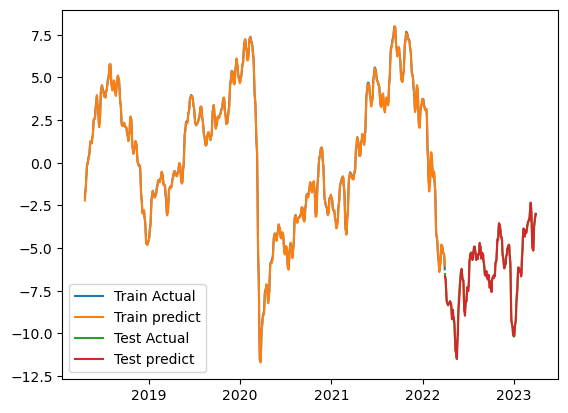

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0029394695069640876
Test_MAE: 0.025369251519441603


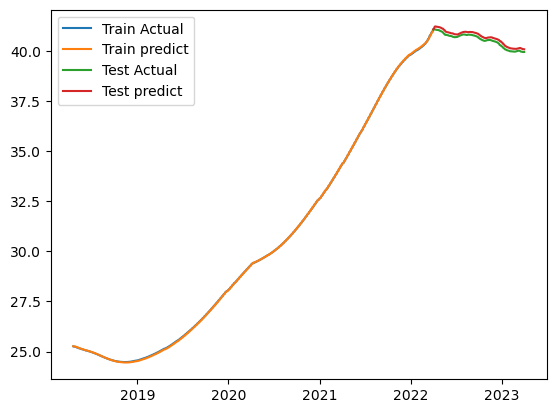

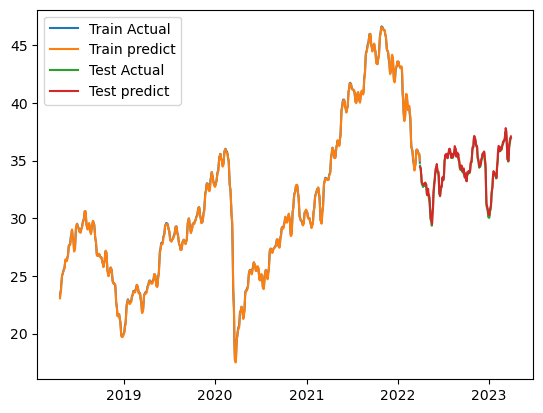

In [52]:
final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(example_train, example_test, show = True)

In [53]:
Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
Y_result.columns = ['Smoothed_Actual', 'Predict']
Y_result = pd.concat([example_actual, Y_result], axis = 1)

## Here is the full combination:

In [54]:
store_path = './Data/Parameter_tuning_0.9997/504_Prediction/SSA-CNN/'
def obtain_all(the_index, window_length = 5, show = None):
    group_name = group[index[the_index]]
    train_All_df, train_files = read_all(train_path + group_name)
    test_All_df, test_files = read_all(test_path + group_name)
    full_All_df, full_files = read_all(full_path + group_name)
    total_length = len(full_All_df)

    for i in range(total_length):
        stock_name = full_files[i]
        train_series = train_All_df[i]
        test_series = test_All_df[i]
        final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(train_series, test_series, show = show)

        Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
        Y_result.columns = ['Smoothed_Actual', 'Predict']
        actual = full_All_df[i][5:]
        Y_result = pd.concat([actual, Y_result], axis = 1)
        Y_result.to_csv(store_path + group_name + '/' + stock_name)


train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.016472516022622584
Test_MAE: 0.0270992211997509


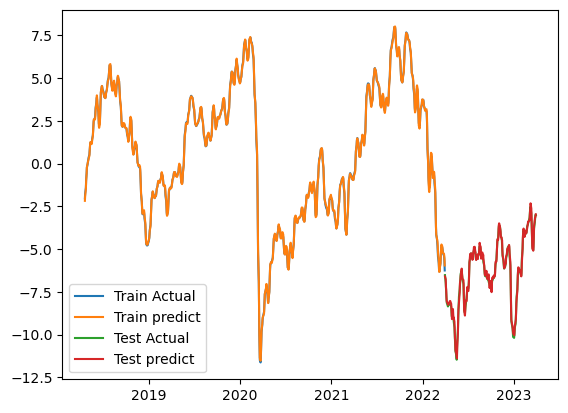

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0023448385763913393
Test_MAE: 0.023523771762847902


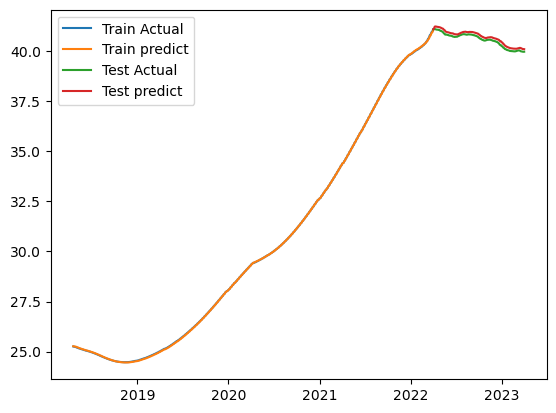

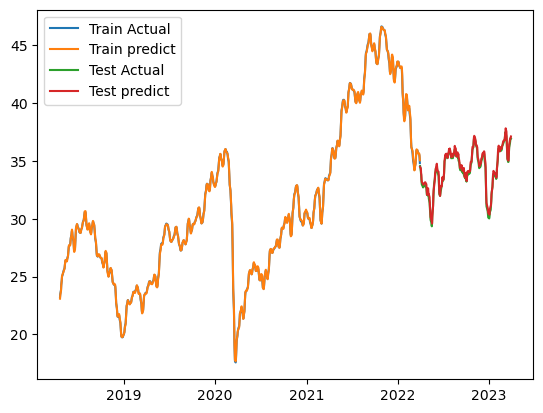

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02202689666301012
Test_MAE: 0.06408907398581505


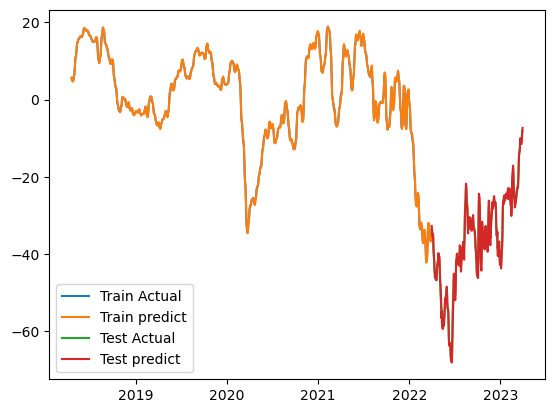

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0012340837623924018
Test_MAE: 0.025340305641293526


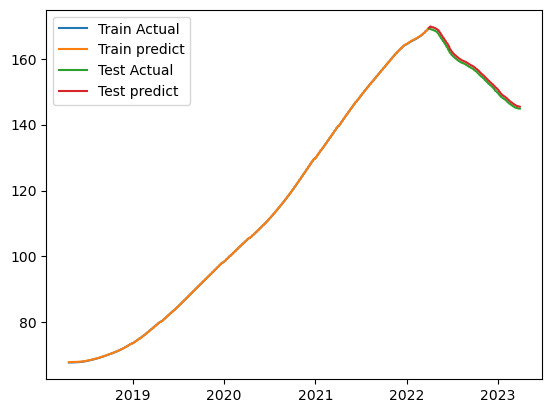

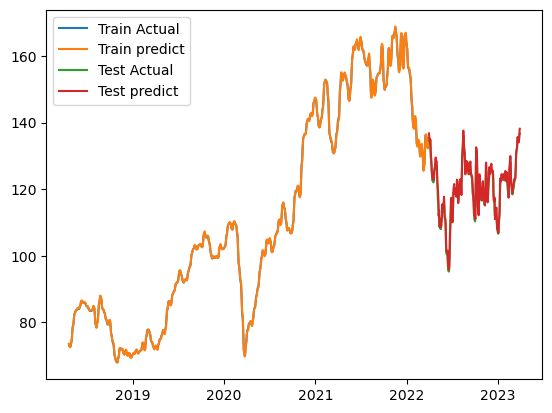

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.010862228833138943
Test_MAE: 0.015551737882196904


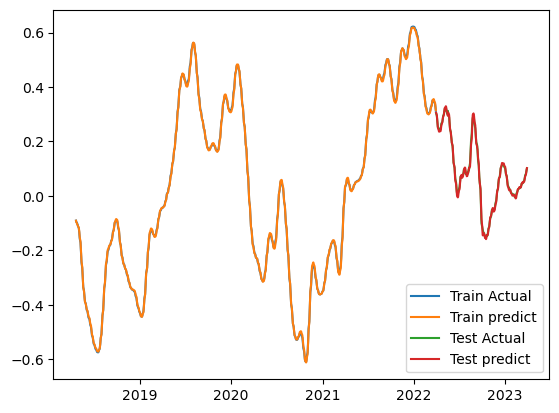

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0030508034862577913
Test_MAE: 0.03868532478809357


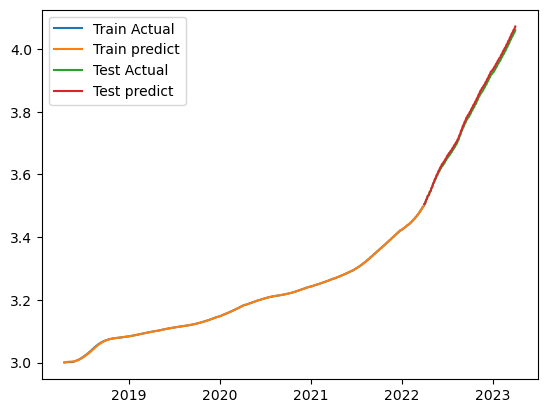

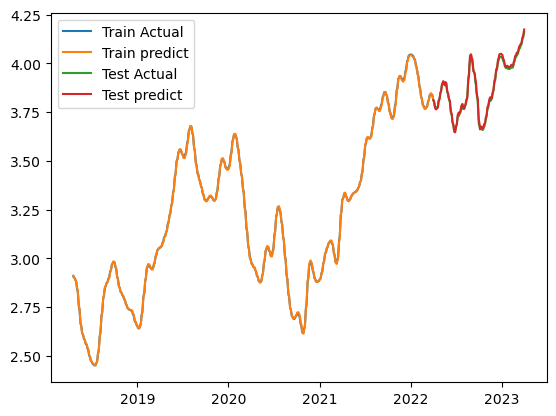

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.026814222708344458
Test_MAE: 0.043468468636274335


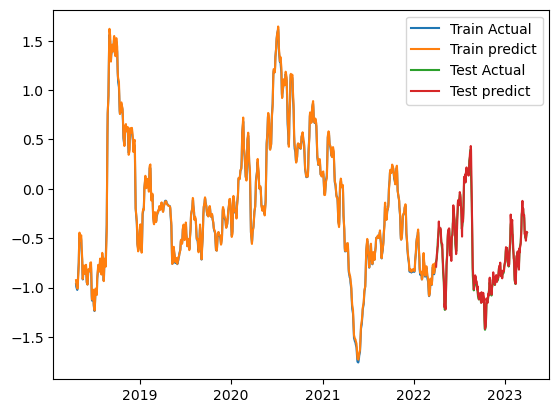

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005774254444986582
Test_MAE: 0.06645960956811905


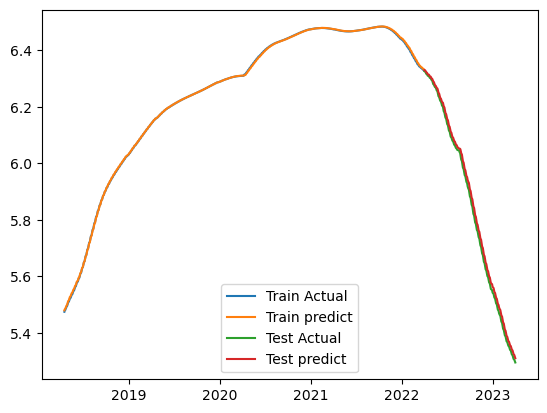

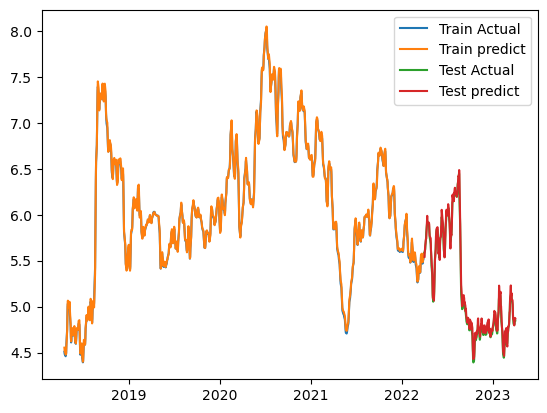

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.016905142366886138
Test_MAE: 0.056711350381374356


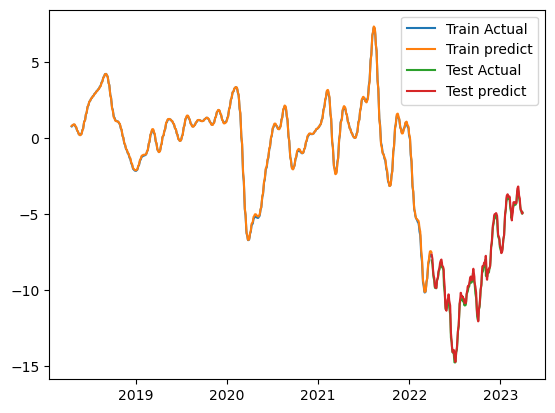

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0006780952680855989
Test_MAE: 0.021896013617515565


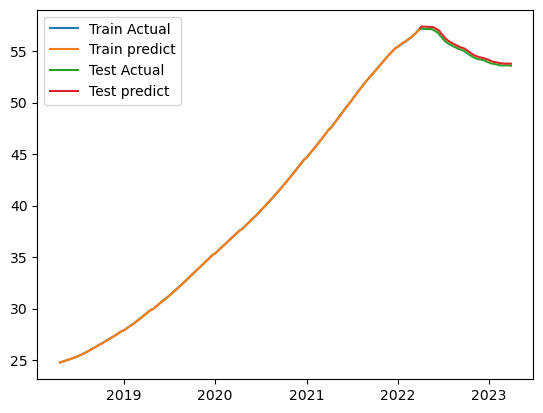

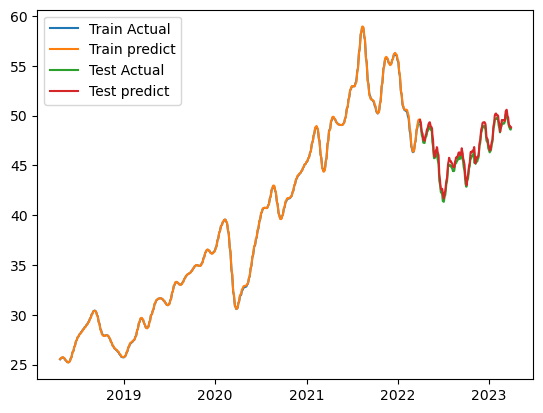

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.015955332294106485
Test_MAE: 0.025915807858109475


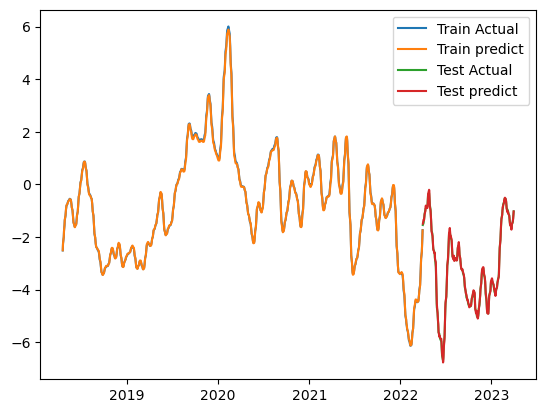

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0013138884445652367
Test_MAE: 0.015588831342756748


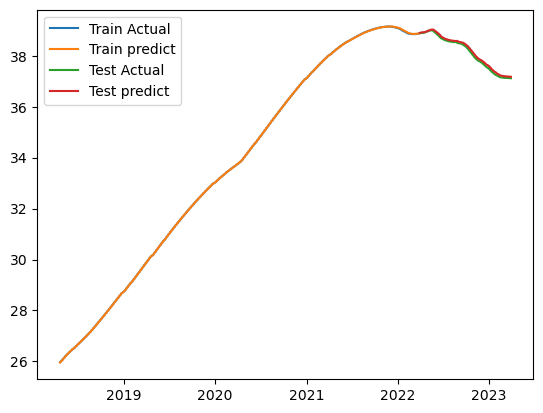

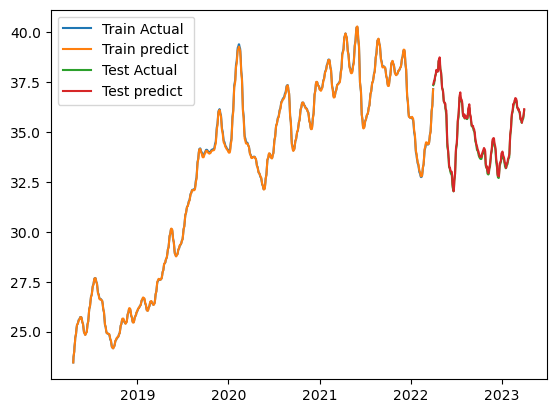

In [55]:
obtain_all(0, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01622194070369005
Test_MAE: 0.0213370218873024


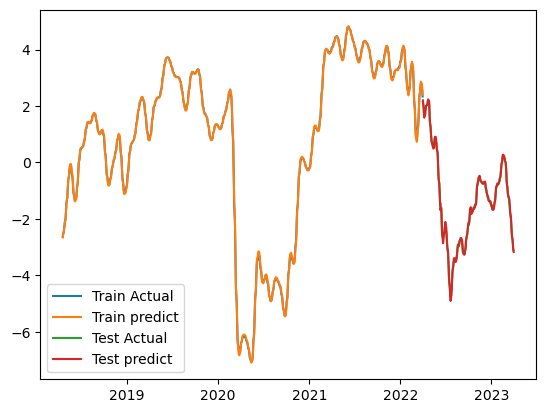

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.012035651132464409
Test_MAE: 0.04581598117947579


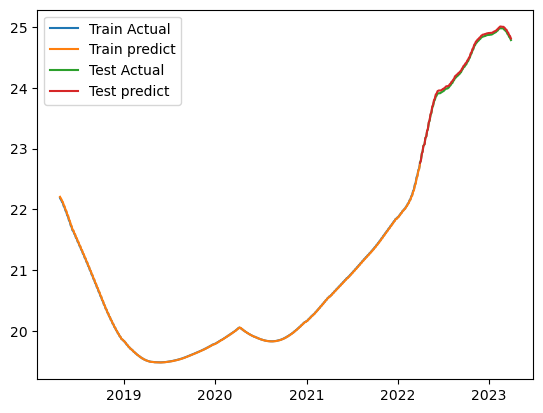

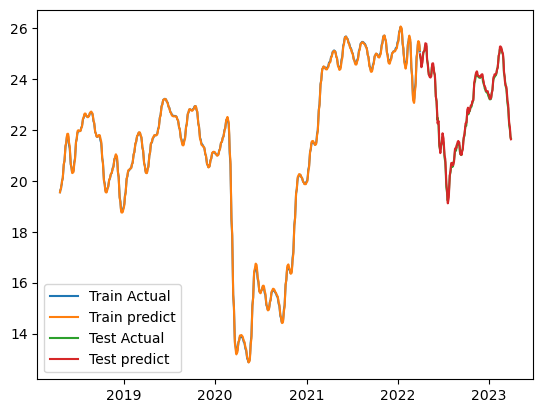

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009885546751320362
Test_MAE: 0.03329196497797966


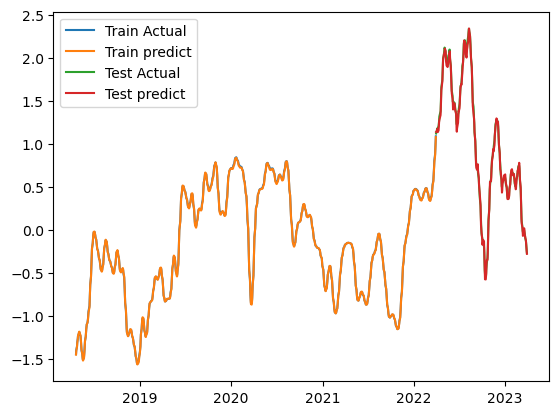

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005316541064530611
Test_MAE: 0.03986348770558834


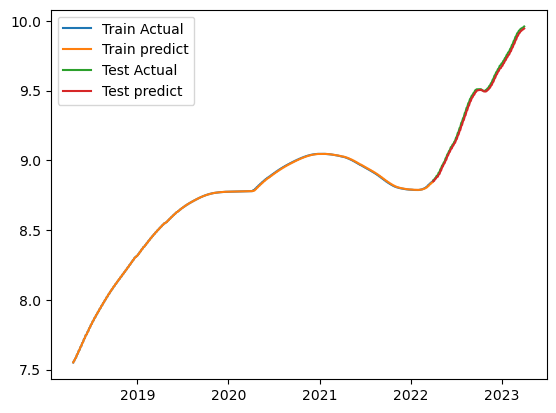

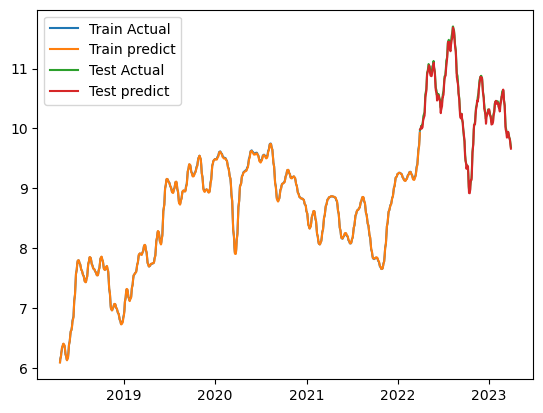

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.011903929896652699
Test_MAE: 0.031250043958425525


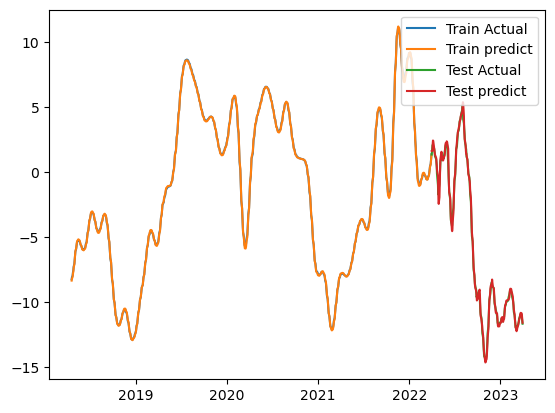

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0018105732277035713
Test_MAE: 0.020274671167135237


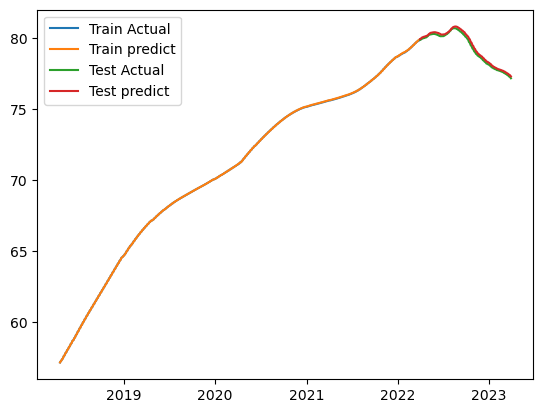

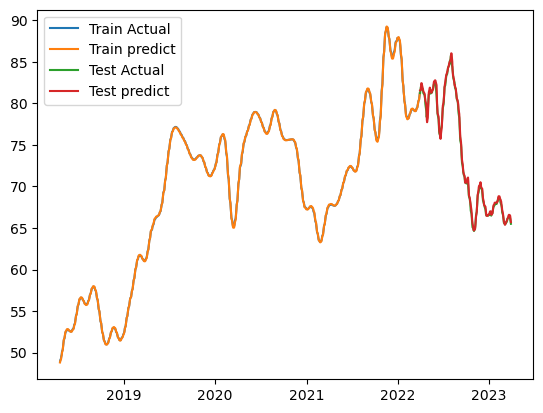

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013740435428917407
Test_MAE: 0.04152042642235756


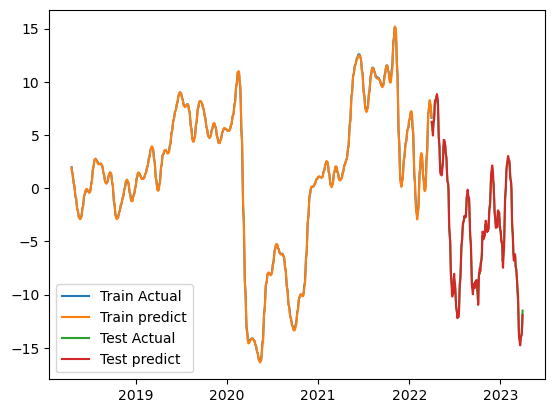

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002952152374200523
Test_MAE: 0.021282070875167848


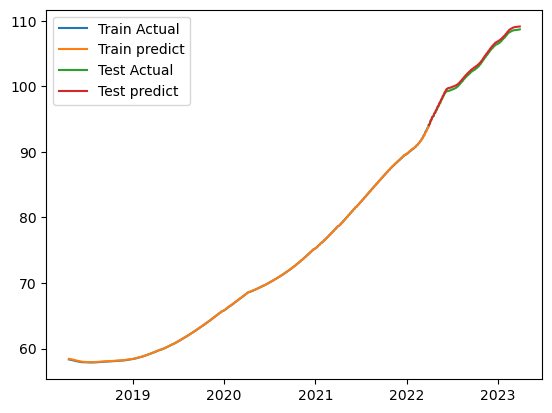

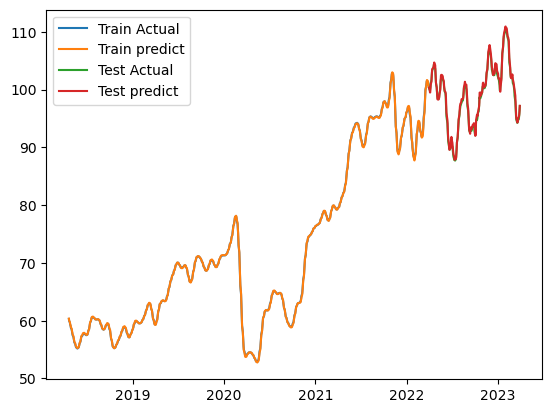

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.022437882795929908
Test_MAE: 0.052805252373218536


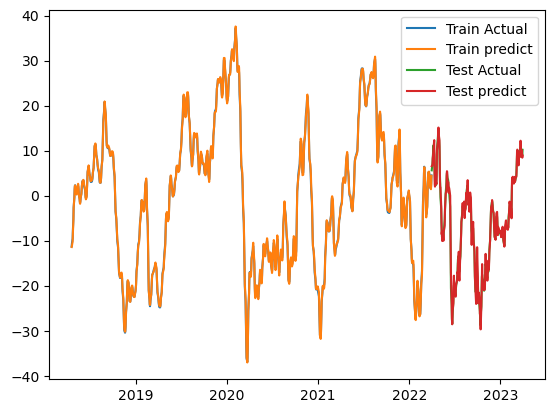

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004820951586589217
Test_MAE: 0.011049168370664119


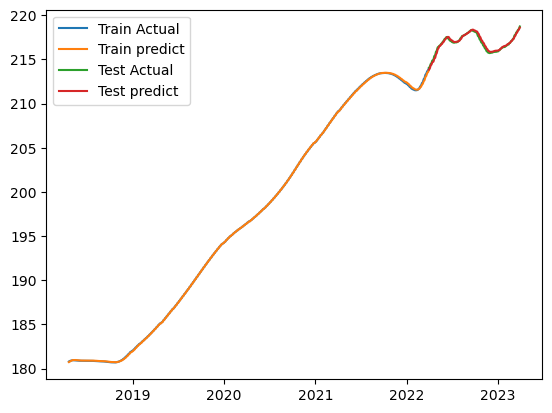

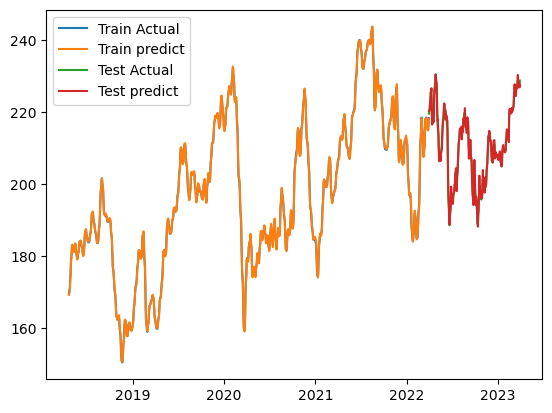

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020075715519487856
Test_MAE: 0.05603432580828667


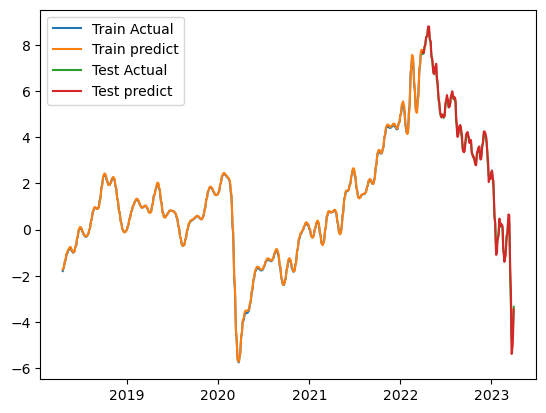

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009903993876650929
Test_MAE: 0.028248561499640345


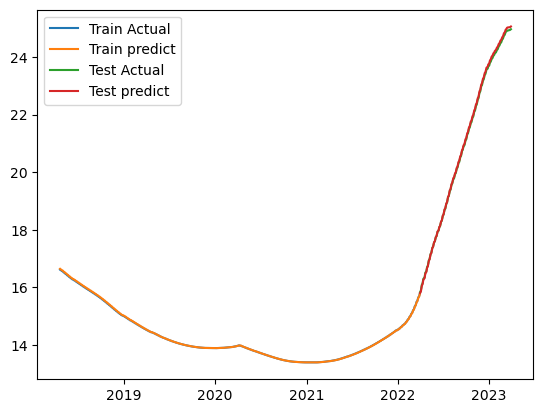

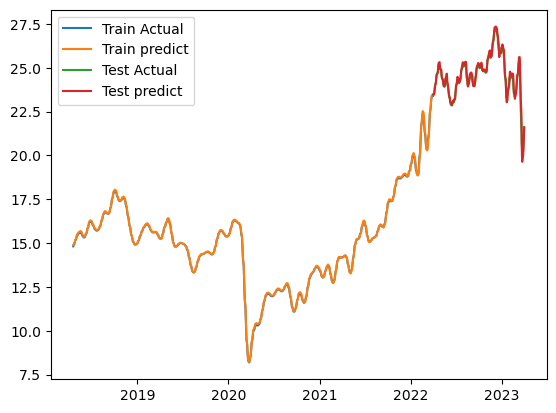

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015052860975265503
Test_MAE: 0.027587885782122613


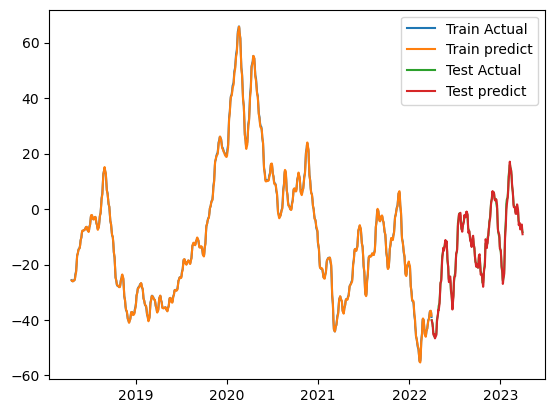

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0018332807812839746
Test_MAE: 0.01139483116567135


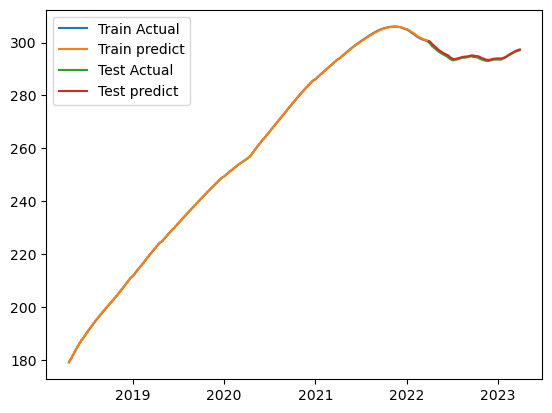

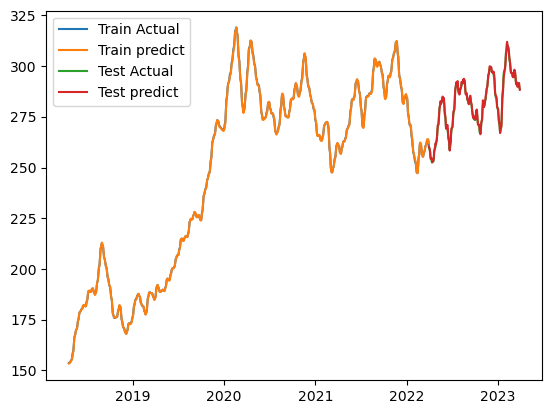

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.018374184146523476
Test_MAE: 0.03717719539999962


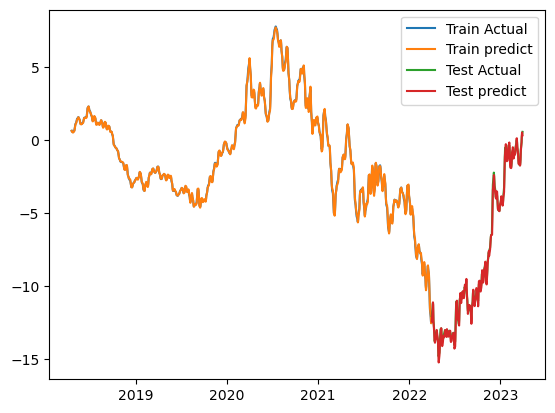

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0012142073130235076
Test_MAE: 0.027597039192914962


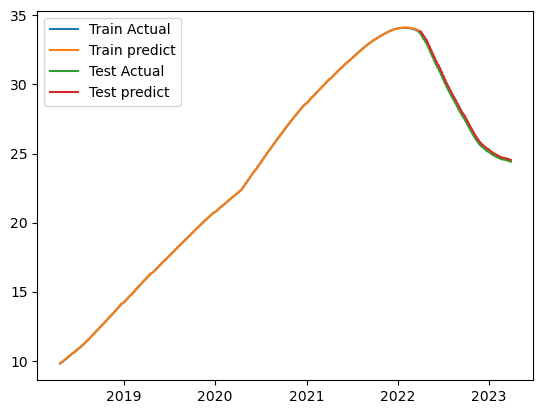

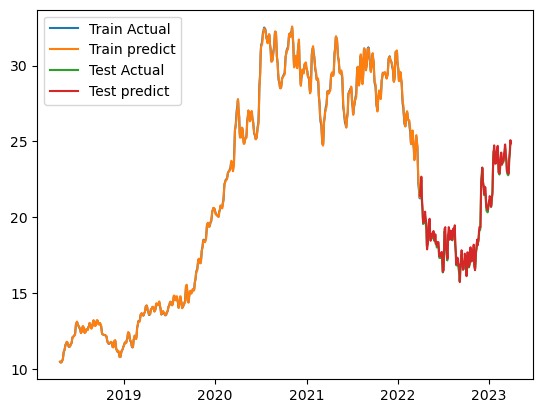

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01691899262368679
Test_MAE: 0.05499737486243248


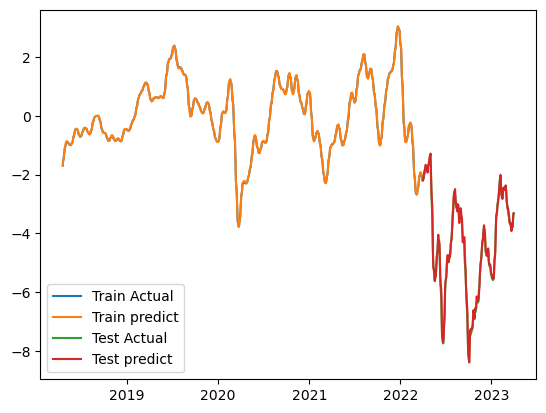

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0008119744132272899
Test_MAE: 0.02642679512500763


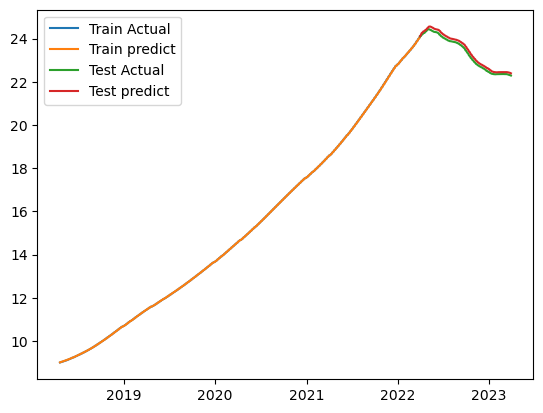

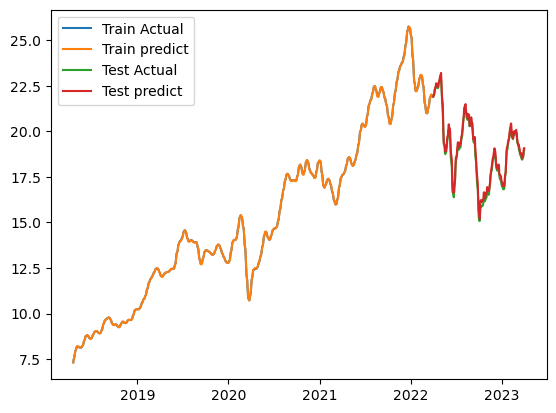

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009657288063317537
Test_MAE: 0.022778676822781563


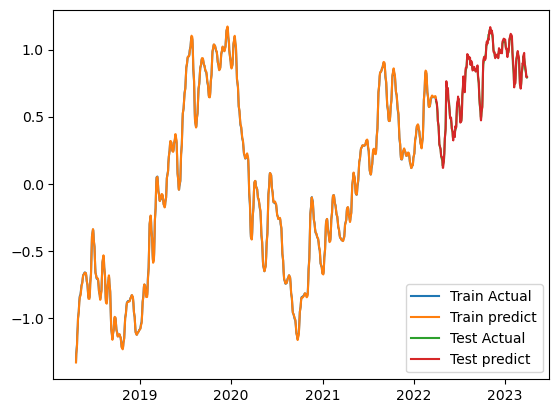

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0012186937616206705
Test_MAE: 0.016404416412115097


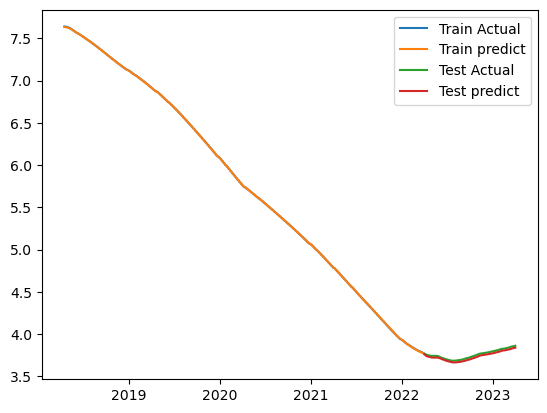

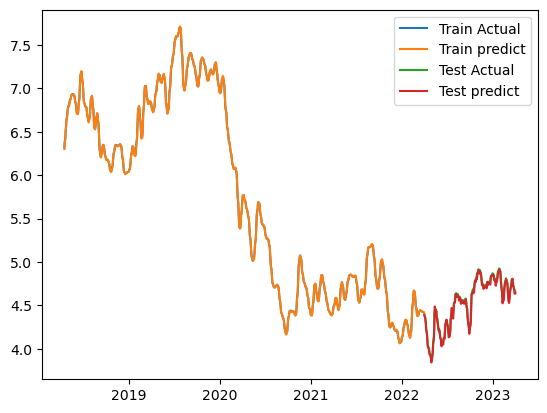

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015587929077446461
Test_MAE: 0.04718355014920235


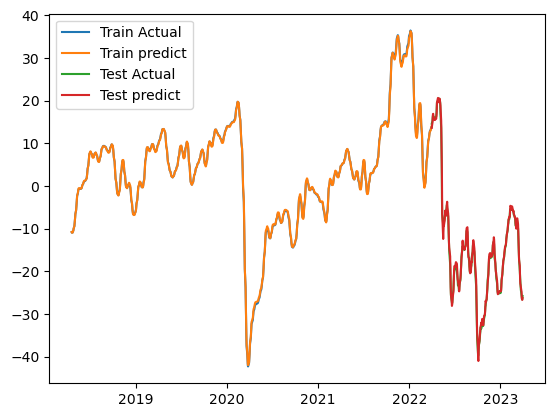

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0014697911450639368
Test_MAE: 0.032639939710497855


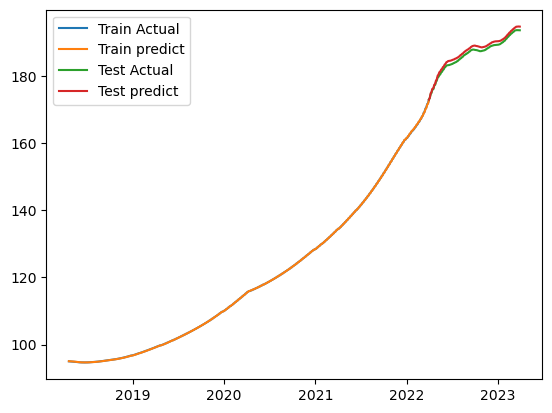

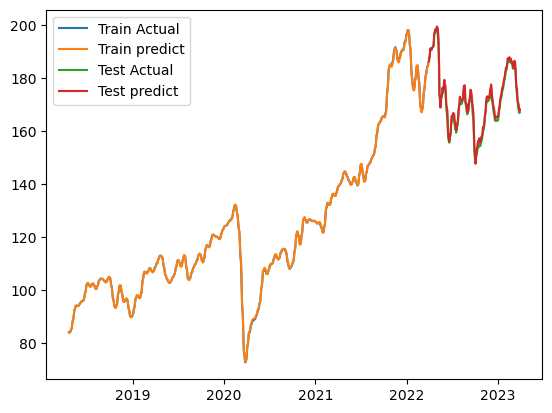

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014234814420342445
Test_MAE: 0.028188395872712137


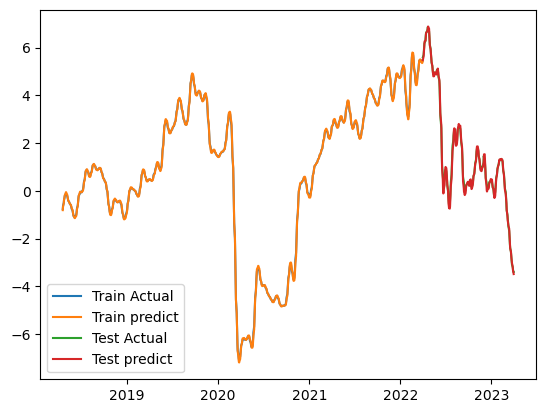

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005839600274339318
Test_MAE: 0.04920155499130487


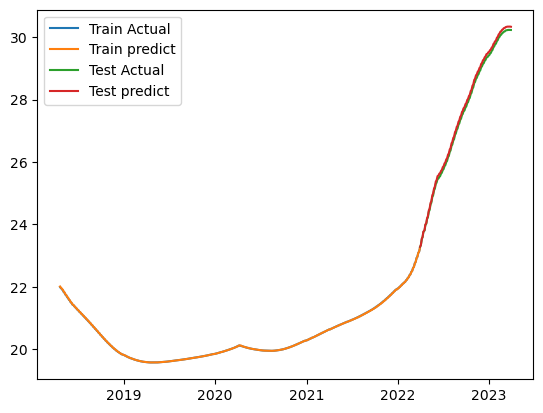

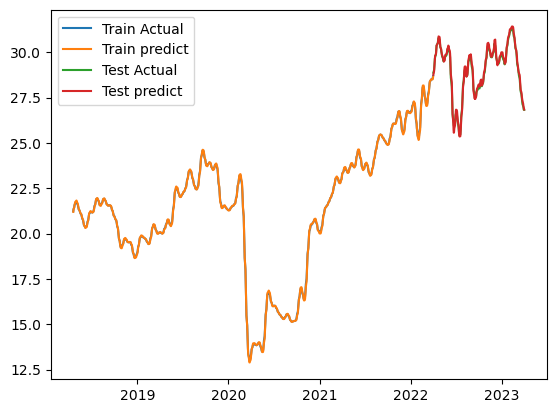

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.011982639133930207
Test_MAE: 0.033085737749934195


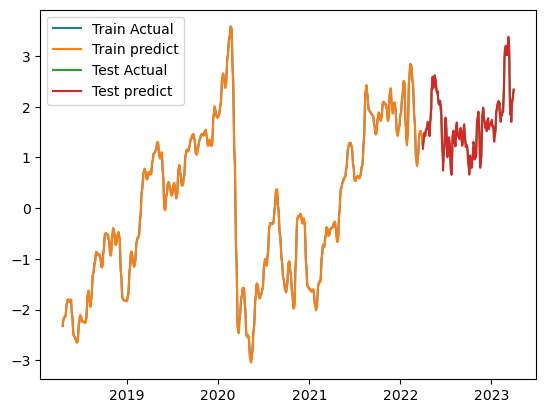

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004838612675666809
Test_MAE: 0.05743714496493339


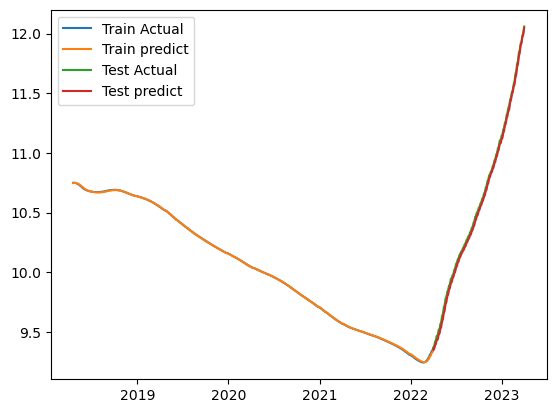

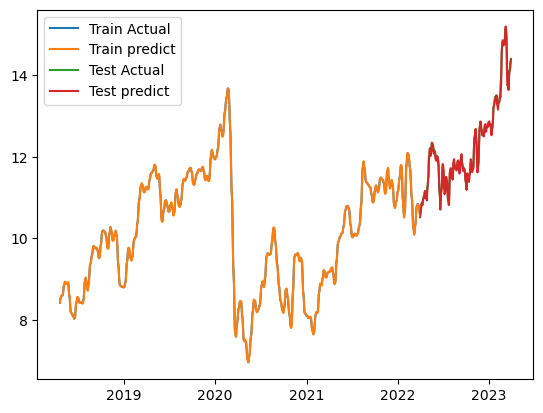

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015370768494904041
Test_MAE: 0.054988736659288405


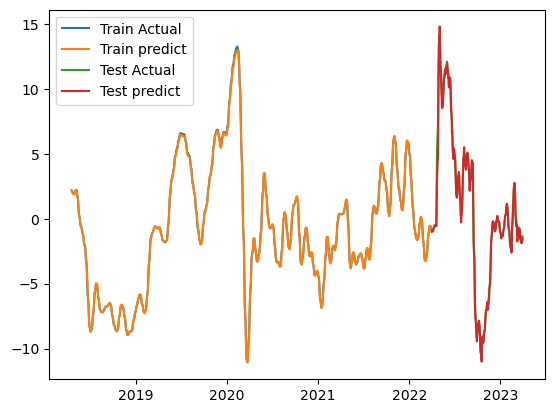

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.004306959453970194
Test_MAE: 0.02838565669953823


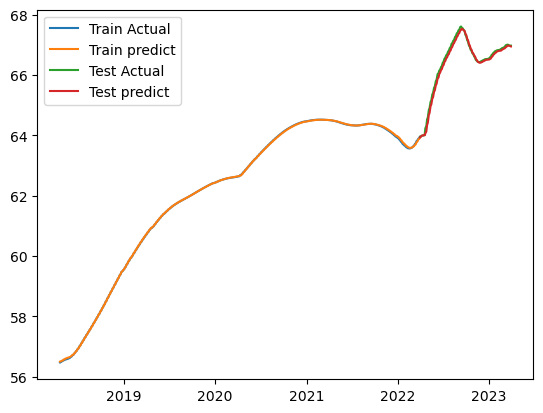

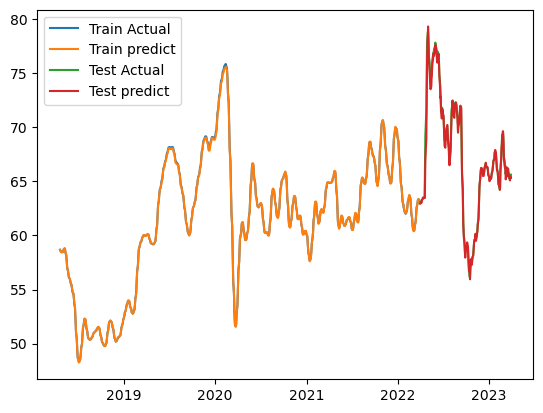

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02056461162865162
Test_MAE: 0.07293222248554229


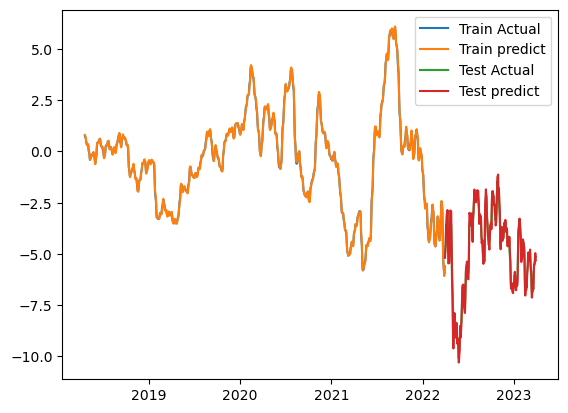

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.000984510307898745
Test_MAE: 0.020009278506040572


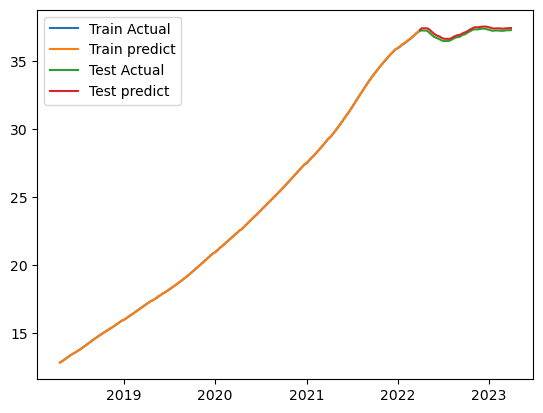

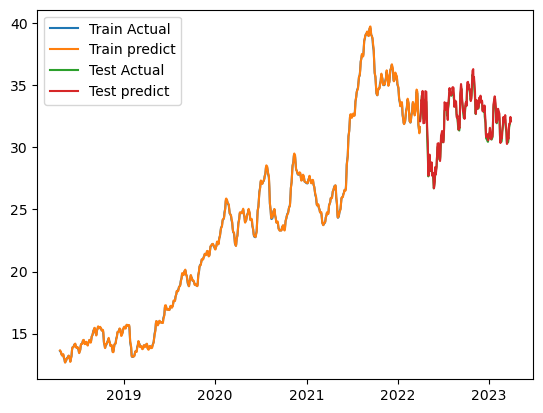

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.017119988054037093
Test_MAE: 0.018446919322013856


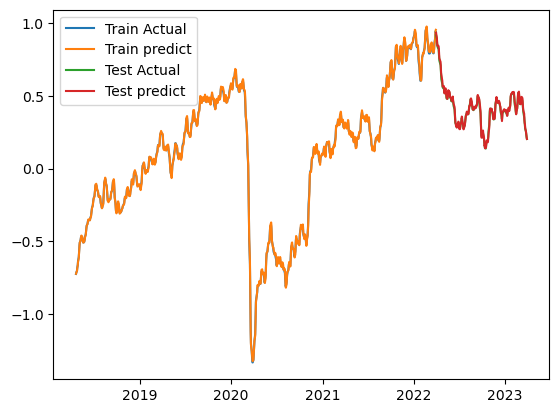

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002068819641135633
Test_MAE: 0.020284983143210412


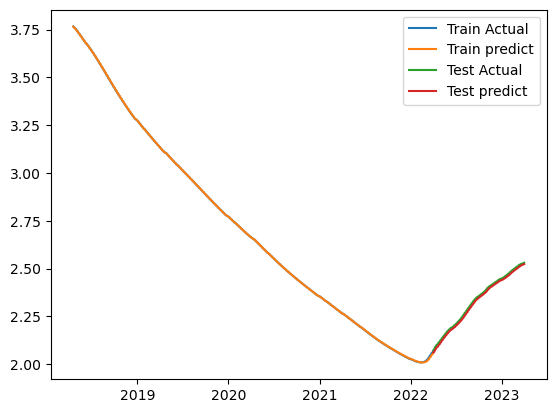

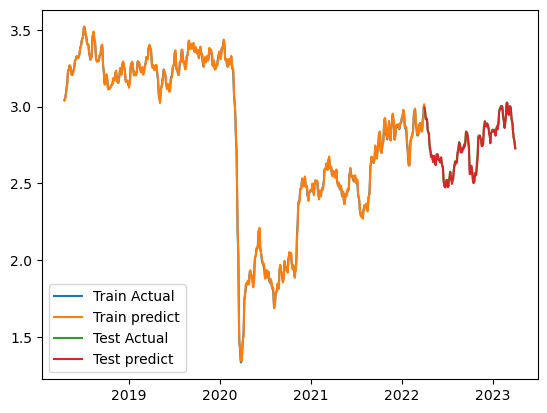

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.018603961542248727
Test_MAE: 0.02715873531997204


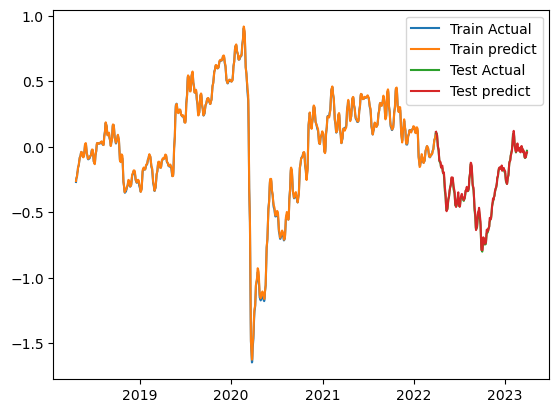

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006346059124916792
Test_MAE: 0.013877075351774692


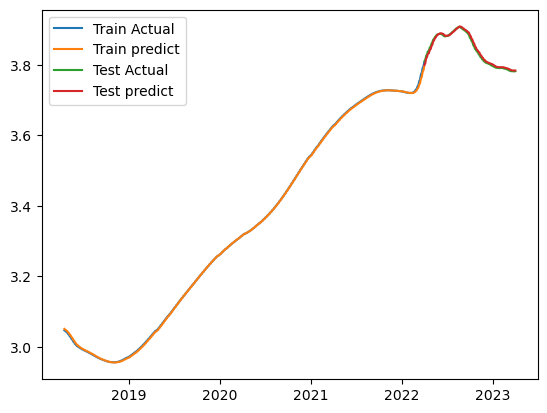

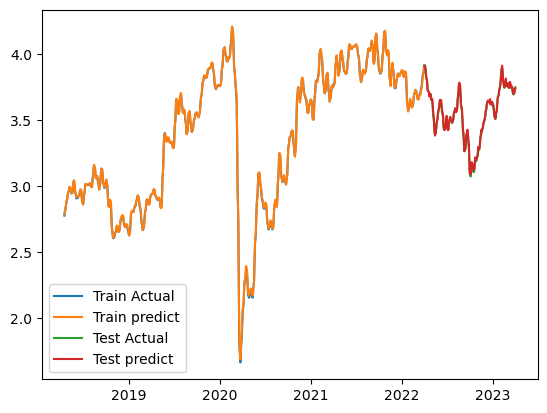

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.012704955041408538
Test_MAE: 0.04890367388725281


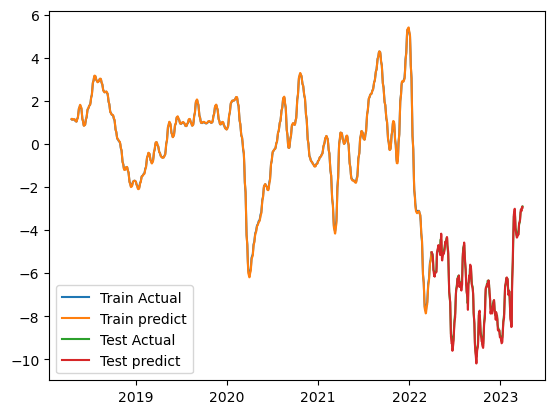

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0017879700404591858
Test_MAE: 0.02345557026565075


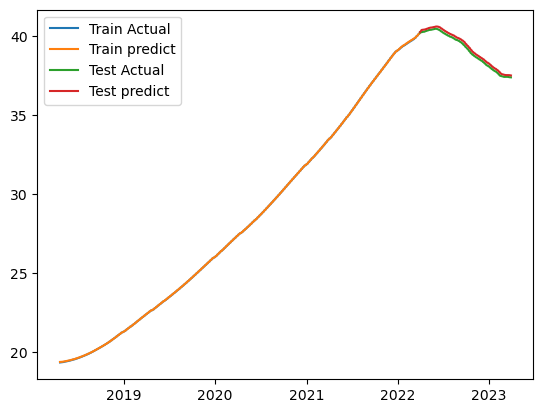

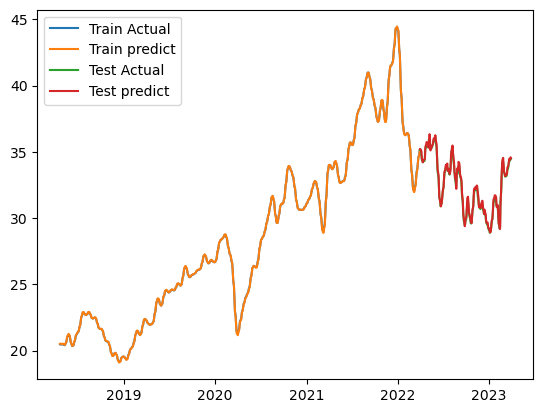

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015202625840902328
Test_MAE: 0.02785007990896702


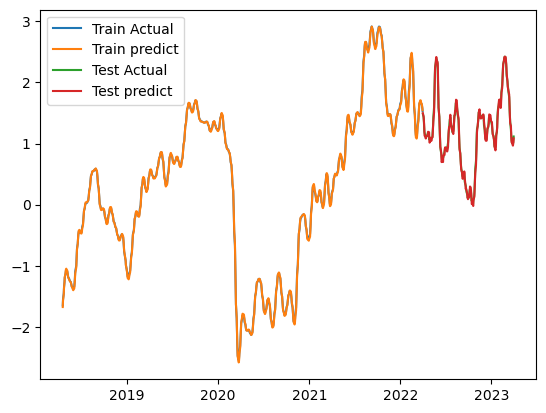

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0024557937867939472
Test_MAE: 0.029027971252799035


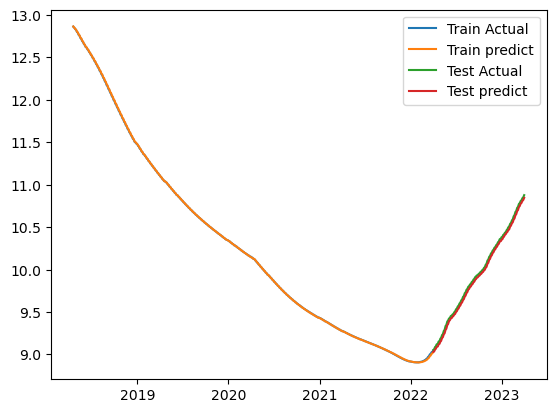

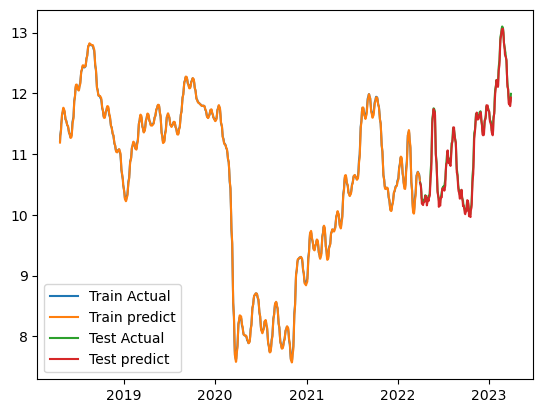

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.012407555244863033
Test_MAE: 0.02007281258702278


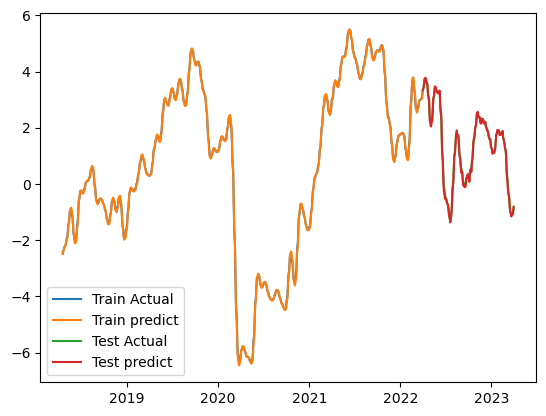

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0031250268686562775
Test_MAE: 0.03601239249110222


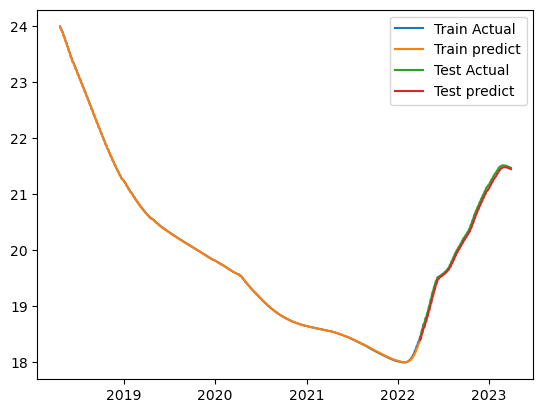

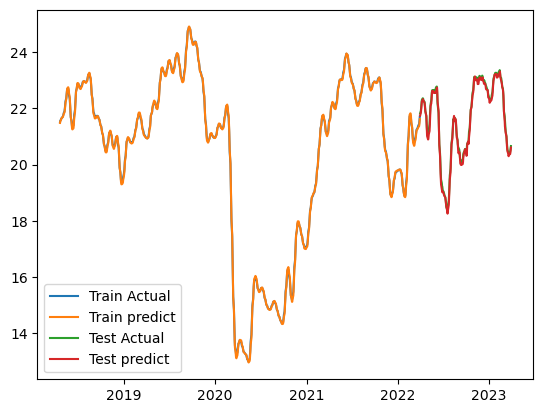

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.045544137805700304
Test_MAE: 0.18203960359096527


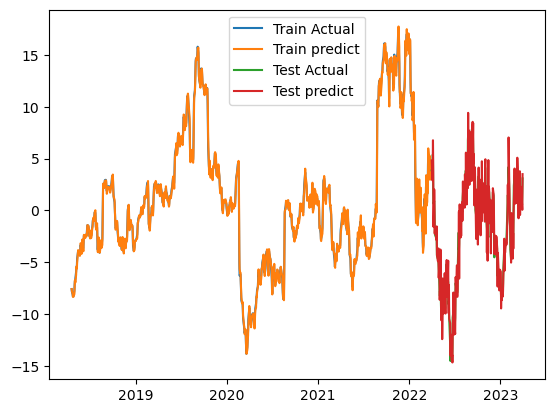

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0015069774817675352
Test_MAE: 0.03191765882074833


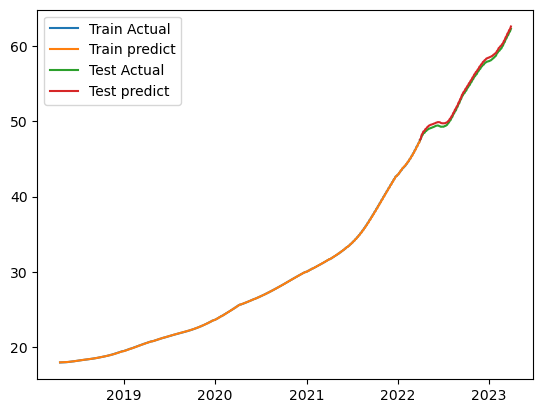

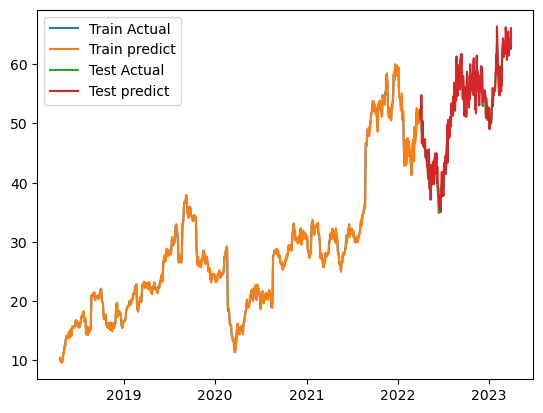

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.027542538195848464
Test_MAE: 0.07363390997052192


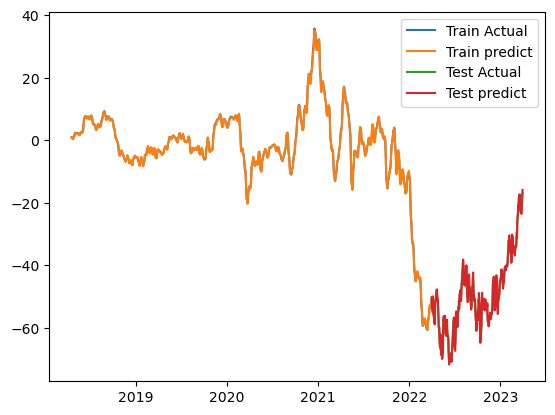

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0012241287622600794
Test_MAE: 0.02774394638836384


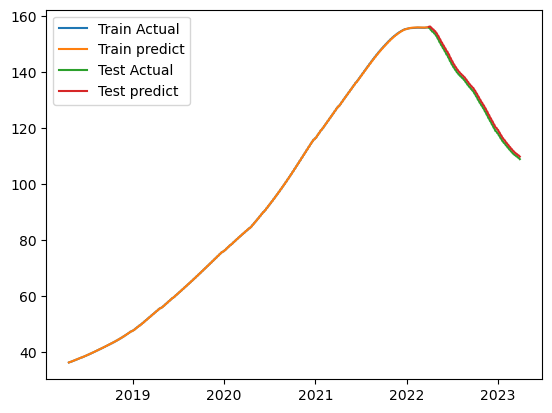

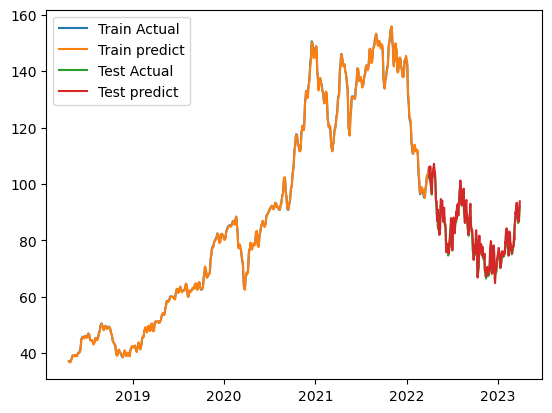

In [56]:
obtain_all(1, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020063154213130475
Test_MAE: 0.01950637251138687


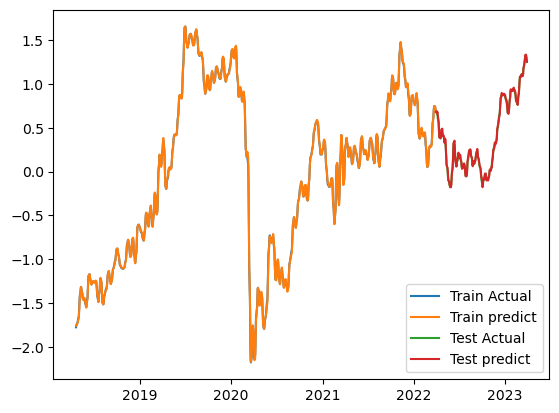

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007020599022507667
Test_MAE: 0.045493132621049884


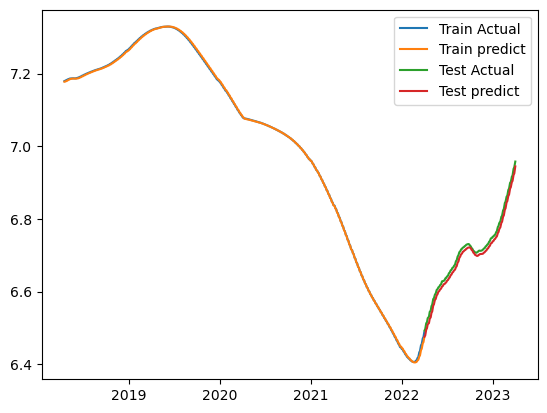

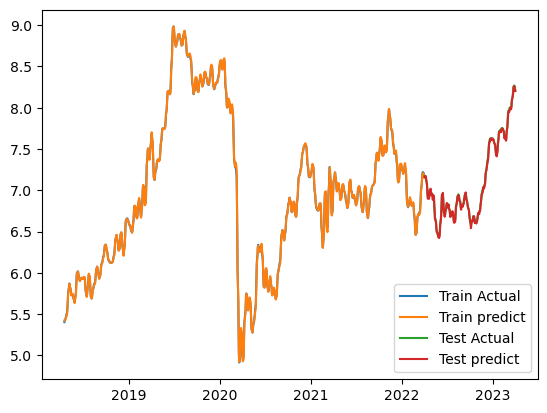

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01710526179522276
Test_MAE: 0.08508633077144623


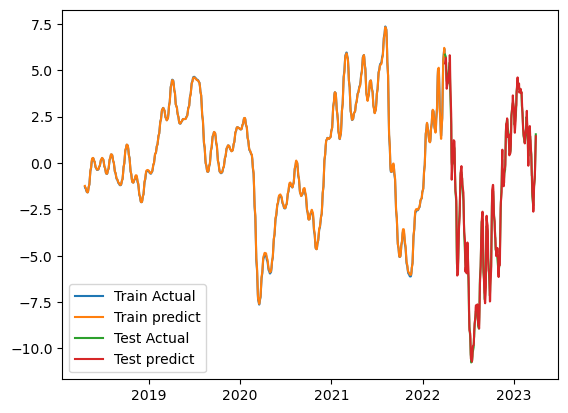

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0018425621325150131
Test_MAE: 0.023616401106119157


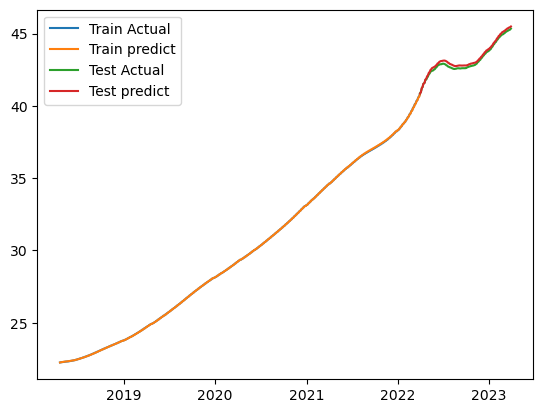

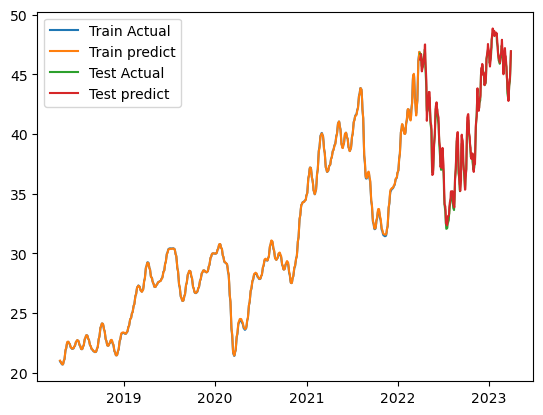

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020221439935266972
Test_MAE: 0.040024202316999435


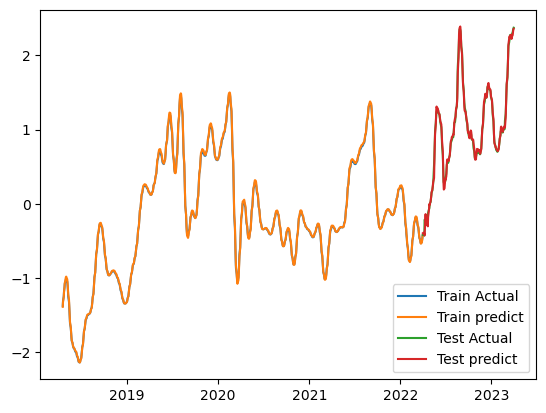

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007506225164979697
Test_MAE: 0.035146017000079154


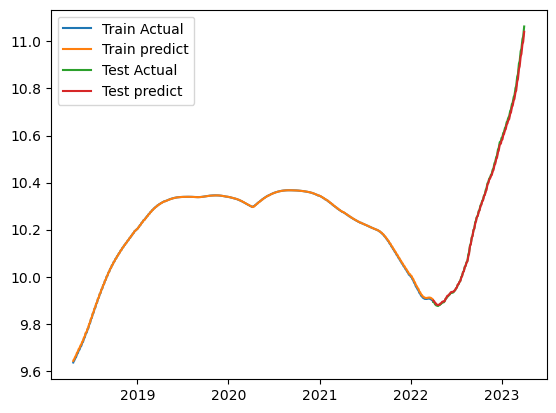

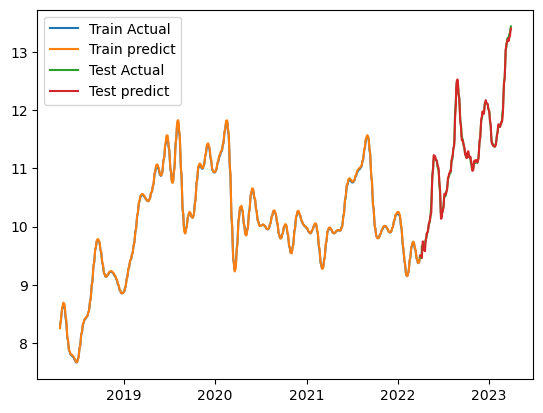

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.030683592706918717
Test_MAE: 0.1418866902589798


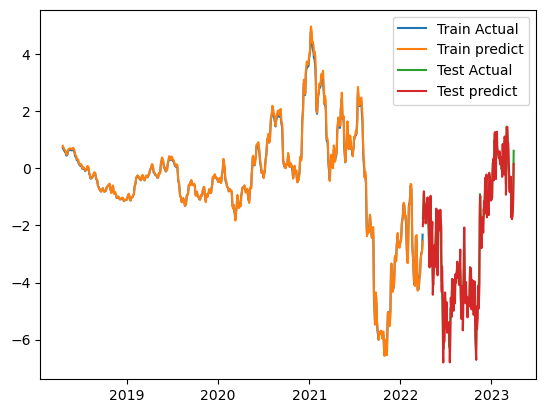

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0008484105579555035
Test_MAE: 0.012708224169909955


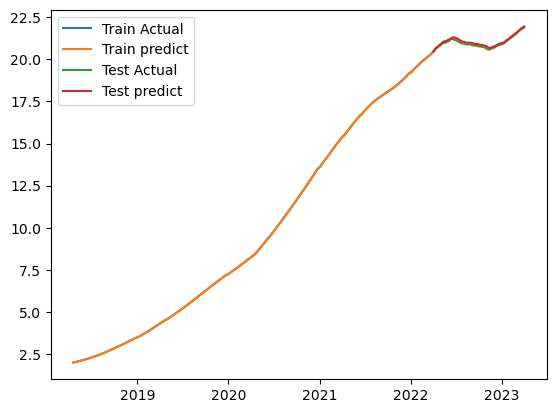

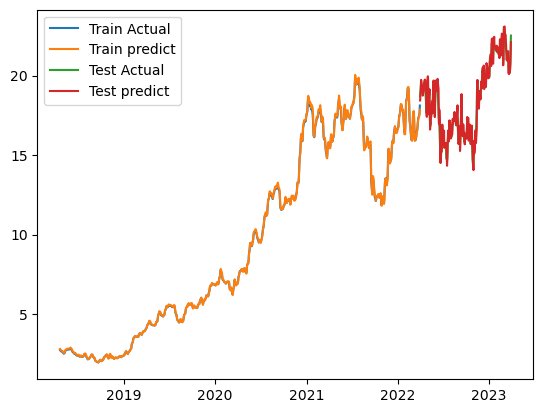

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.025617331266403198
Test_MAE: 0.23281248807907104


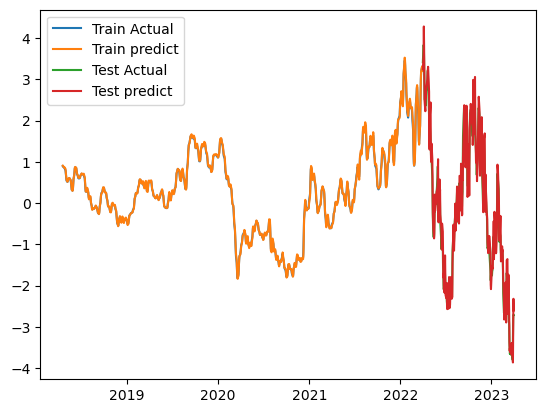

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0016842541983351112
Test_MAE: 0.04842199832201004


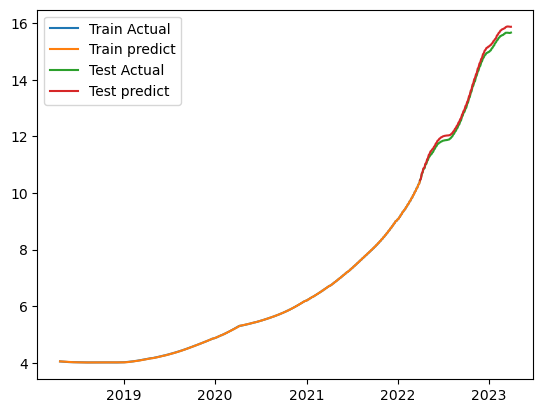

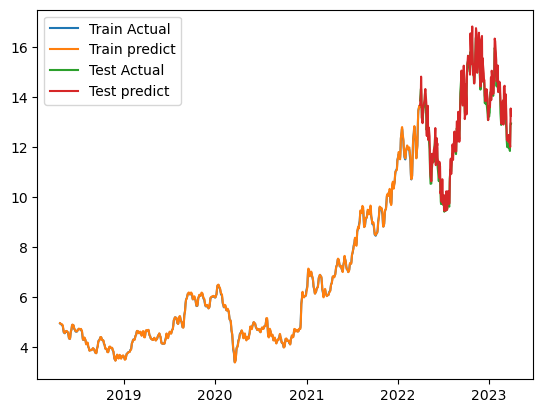

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013688116893172264
Test_MAE: 0.05530682504177094


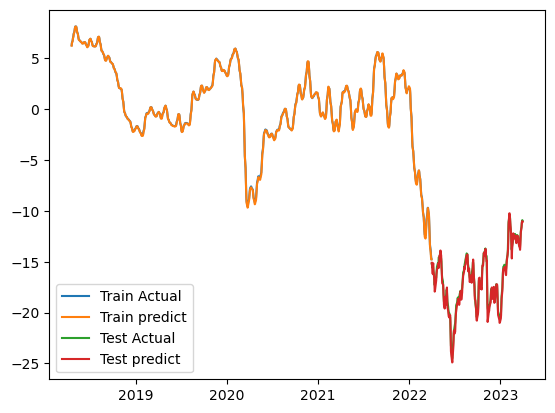

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0018486735527403653
Test_MAE: 0.03318164460361004


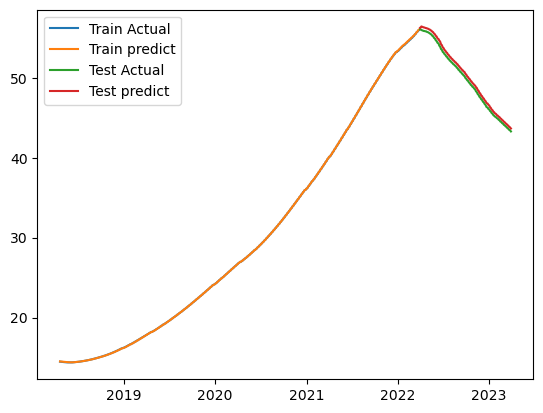

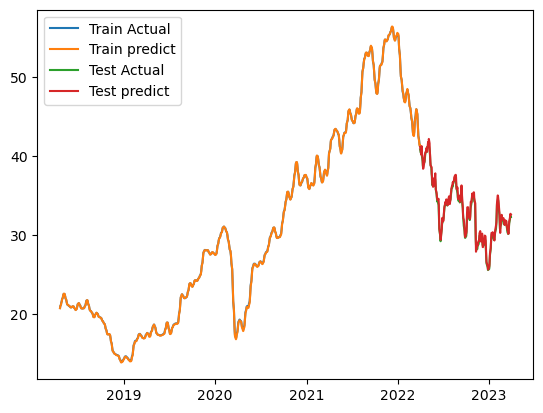

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.030645456910133363
Test_MAE: 0.2749523282051086


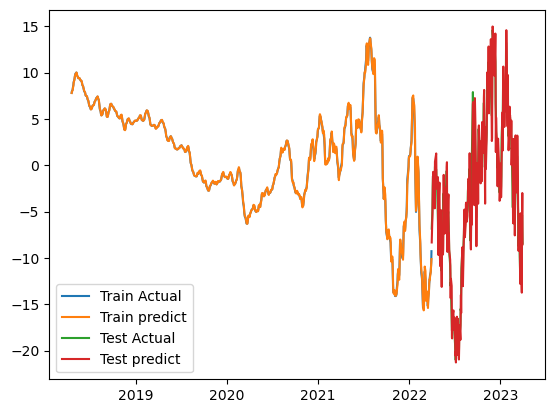

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0012058213469572365
Test_MAE: 0.013424159400165081


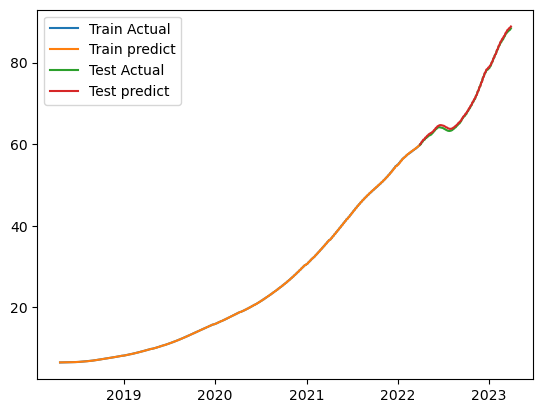

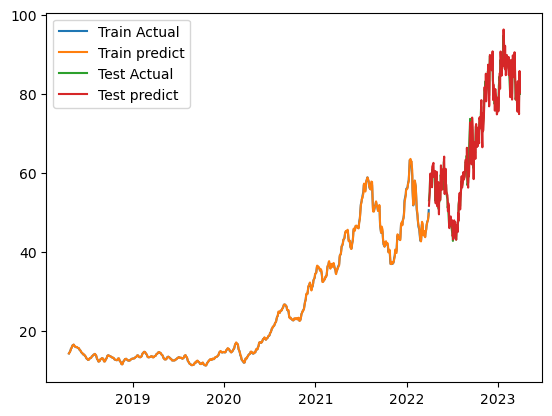

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02490139603614807
Test_MAE: 0.038252173364162444


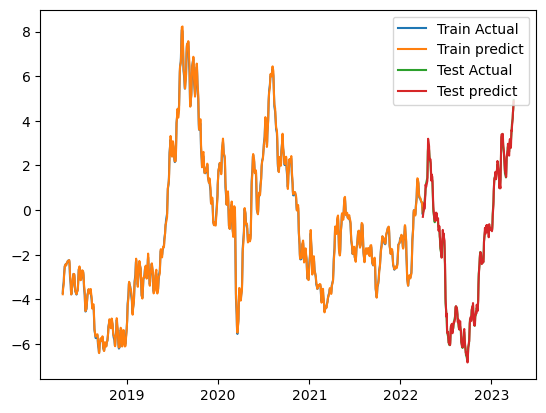

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005892287846654654
Test_MAE: 0.027906909584999084


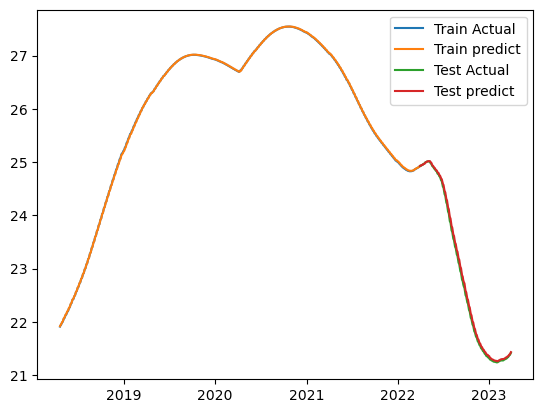

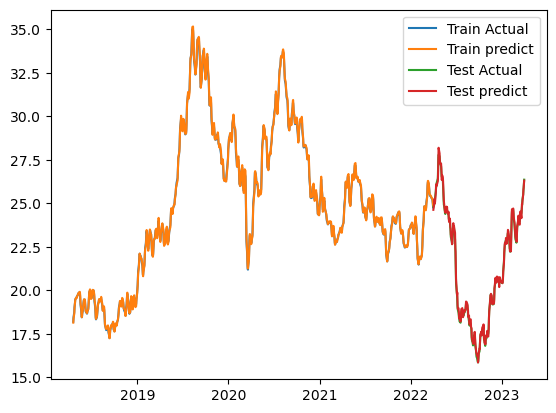

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.07399128824472427
Test_MAE: 0.09709532856941223


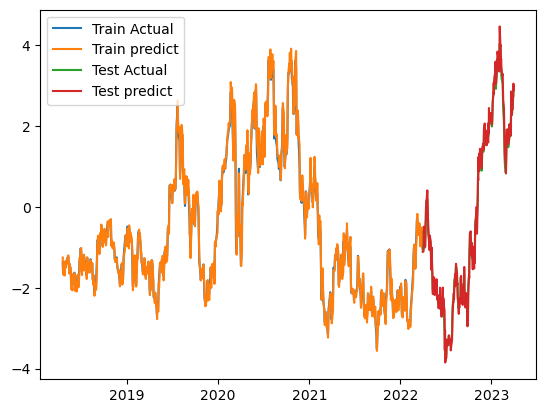

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004650442488491535
Test_MAE: 0.034488645195960996


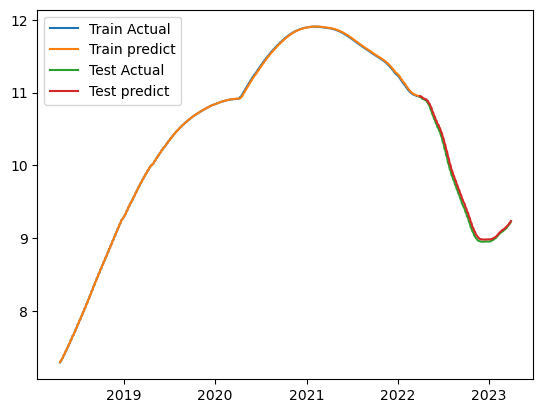

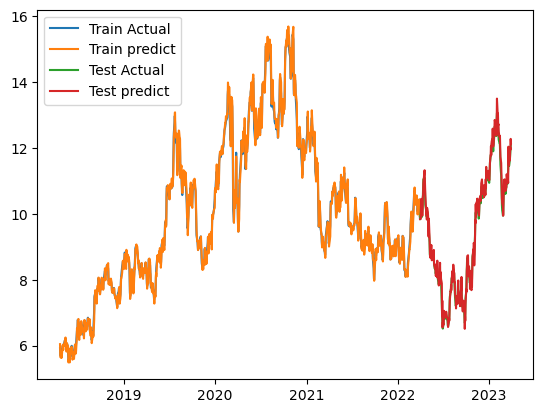

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02214478626847267
Test_MAE: 0.05318151190876961


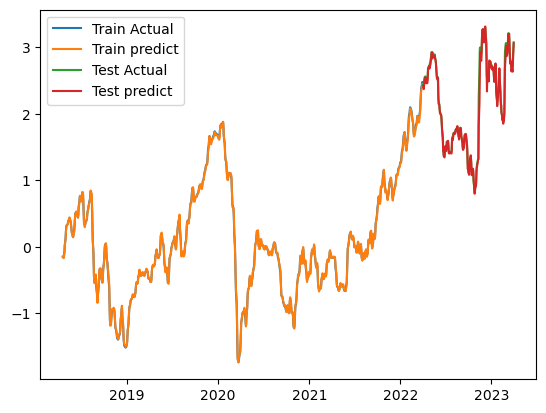

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0017397586023434996
Test_MAE: 0.028646567091345786


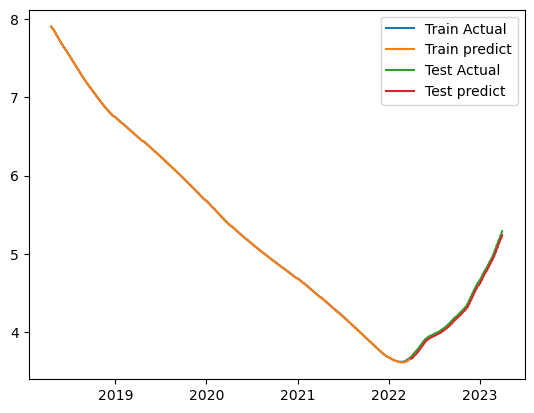

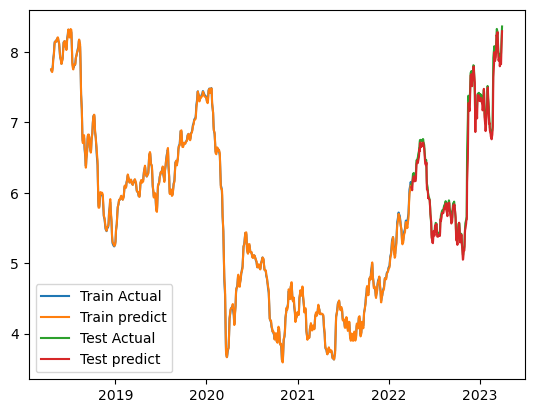

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.060368627309799194
Test_MAE: 0.2714940011501312


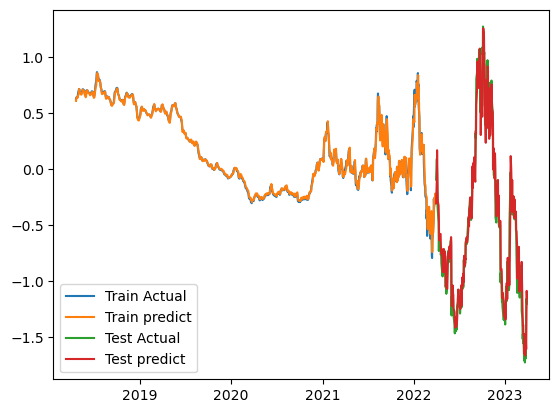

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002879781508818269
Test_MAE: 0.05460598096251488


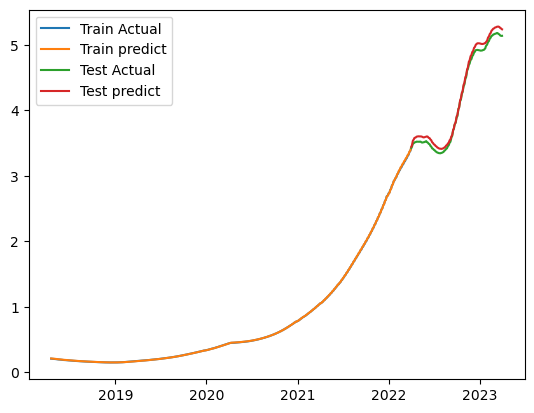

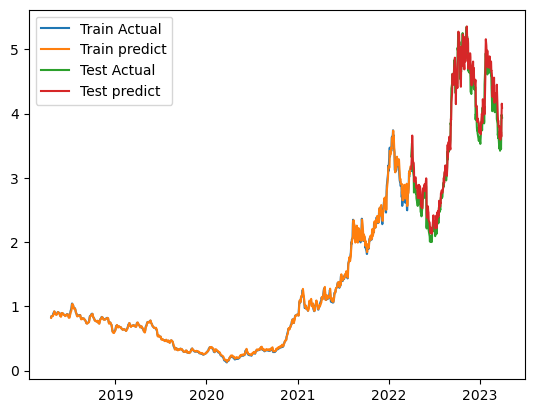

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.021906879171729086
Test_MAE: 0.03634260445833206


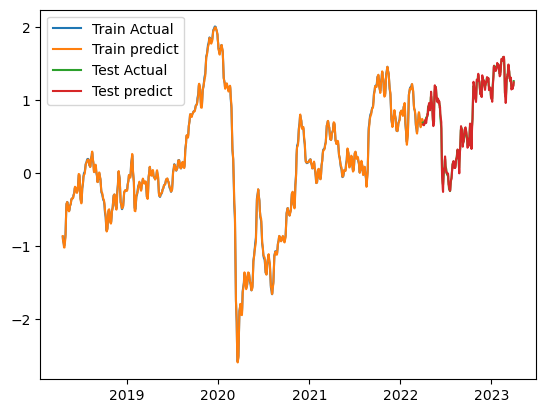

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004629091313108802
Test_MAE: 0.03237234726548195


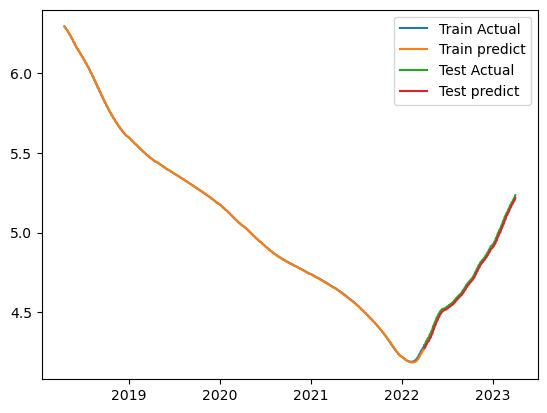

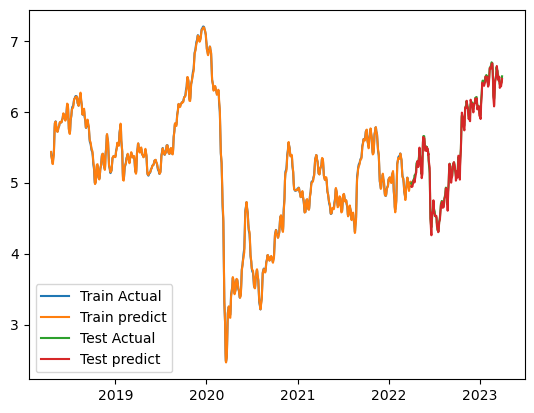

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.018793890438973903
Test_MAE: 0.05749281495809555


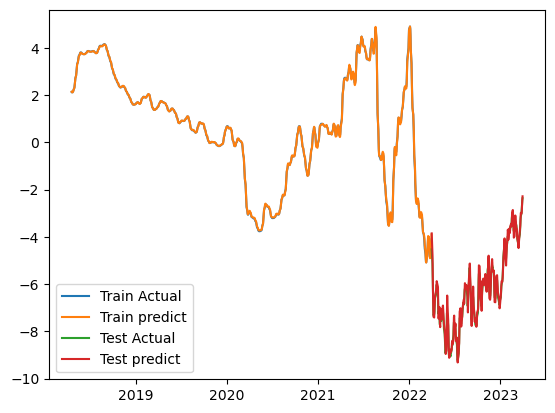

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.00186430886387825
Test_MAE: 0.03052806034684181


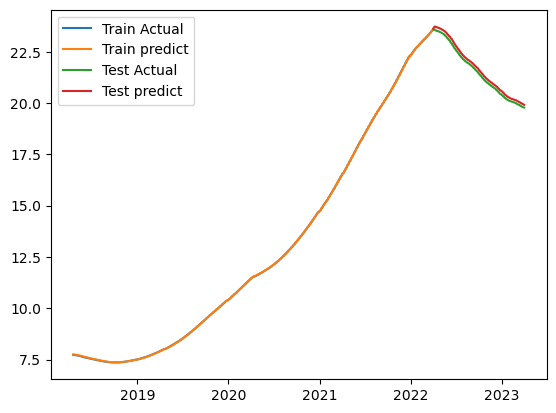

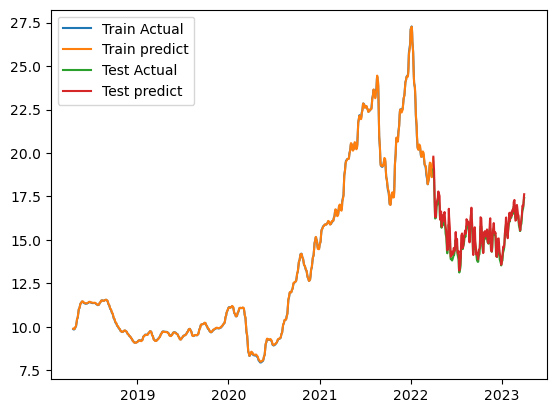

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01452961154282093
Test_MAE: 0.06853382885456086


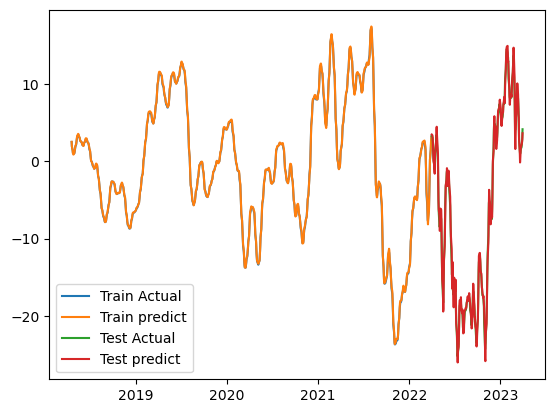

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0016285616671666502
Test_MAE: 0.013734466023743152


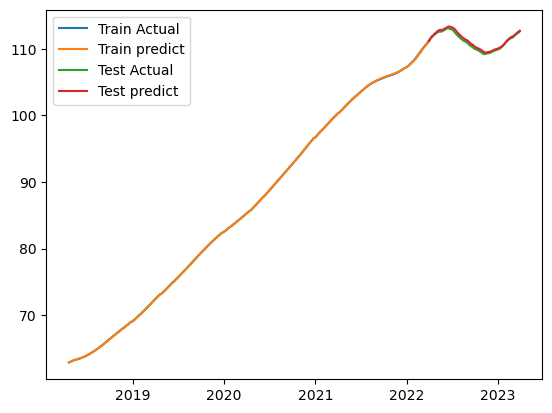

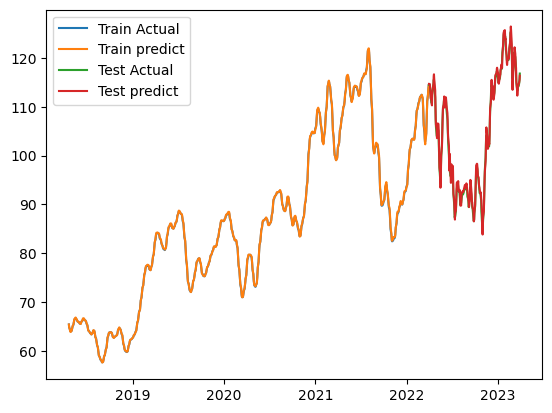

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.020517806336283684
Test_MAE: 0.09107224941253662


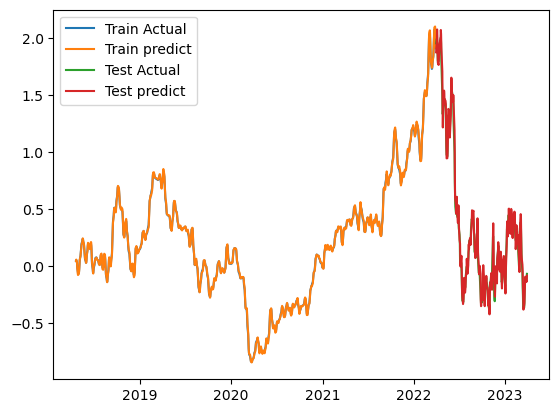

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006672377698123455
Test_MAE: 0.034812108520418404


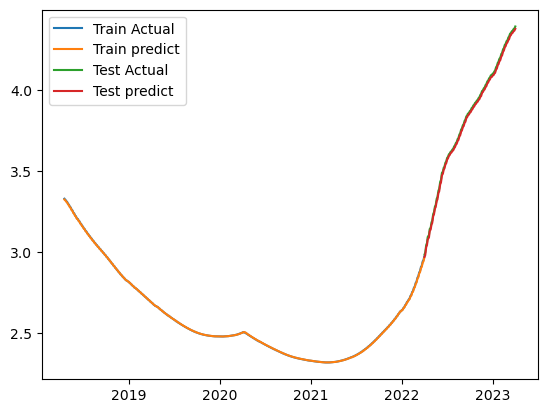

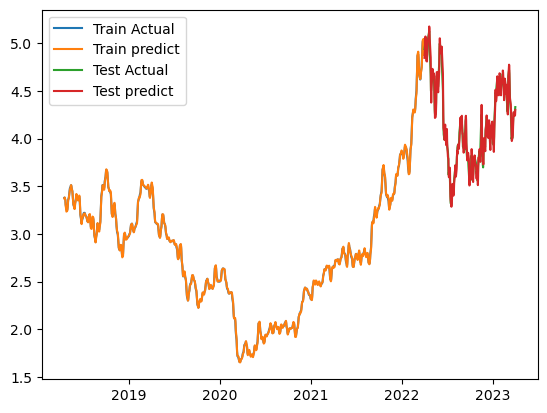

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.011195350997149944
Test_MAE: 0.025791296735405922


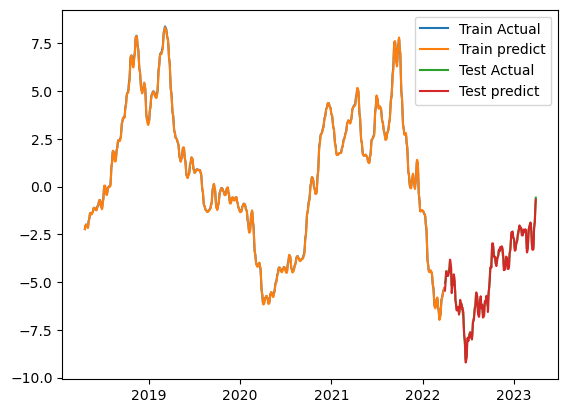

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002158784819766879
Test_MAE: 0.026949454471468924


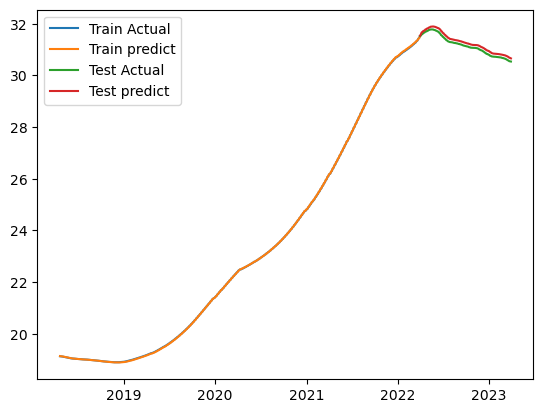

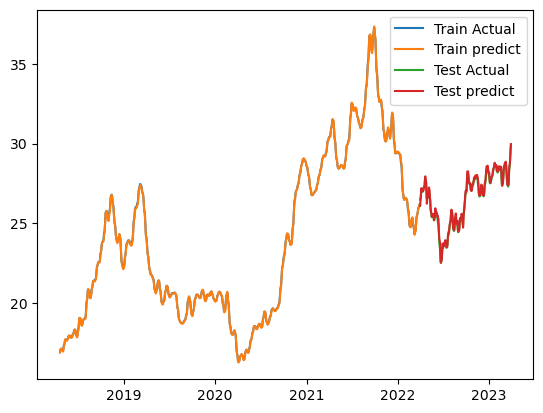

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02051132433116436
Test_MAE: 0.042425426095724104


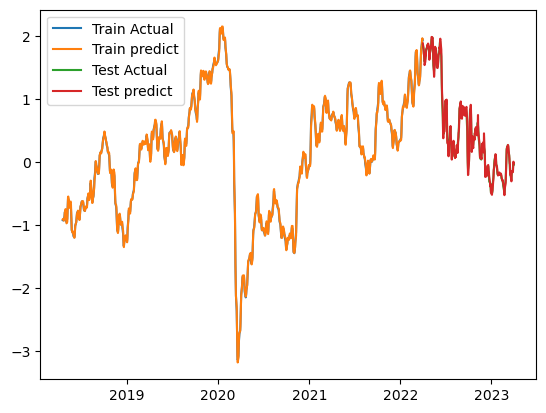

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006504089199006557
Test_MAE: 0.0794994130730629


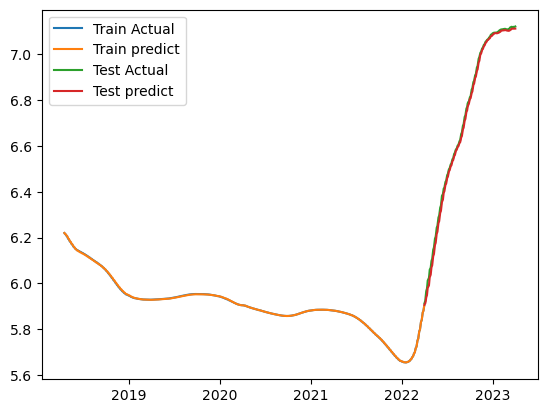

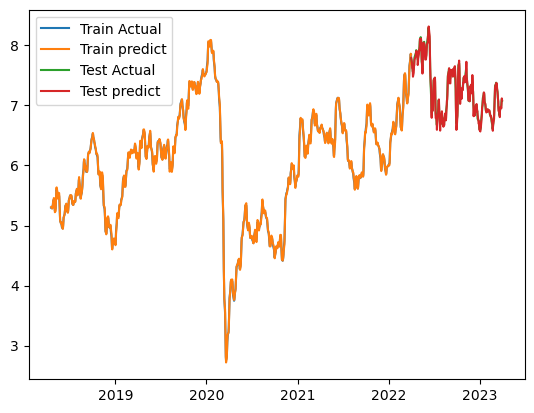

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02208809442818165
Test_MAE: 0.020546235516667365


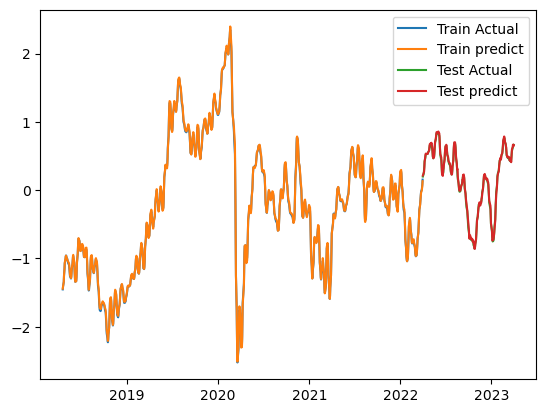

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005820869980379939
Test_MAE: 0.011822448670864105


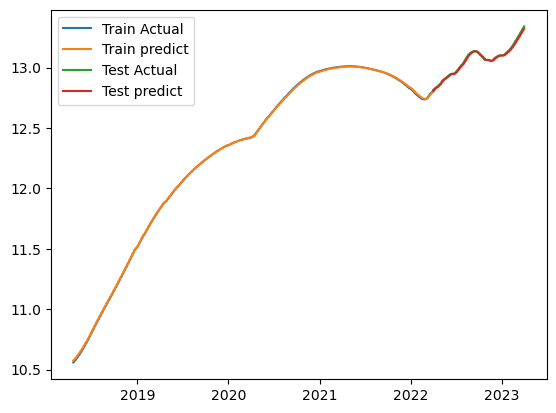

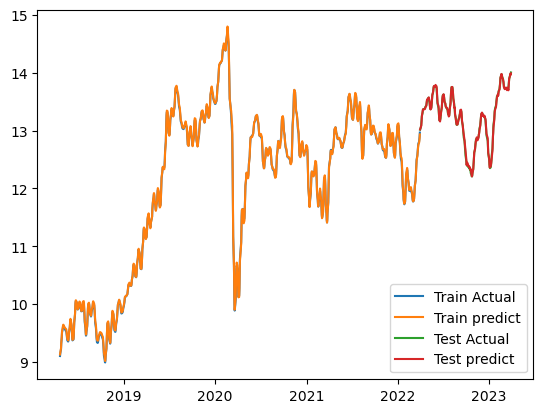

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019474491477012634
Test_MAE: 0.04757762774825096


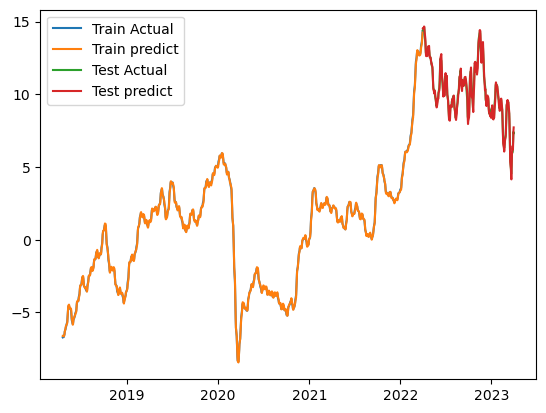

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0030335009563714267
Test_MAE: 0.039606581628322604


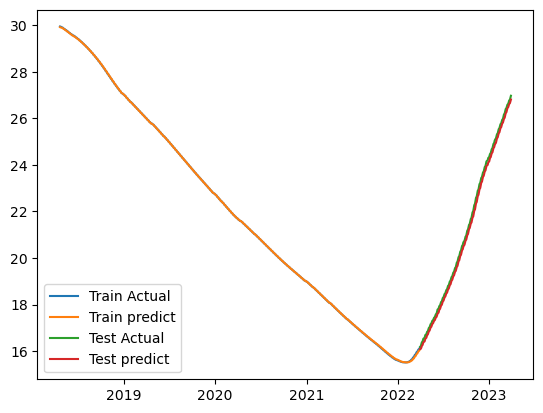

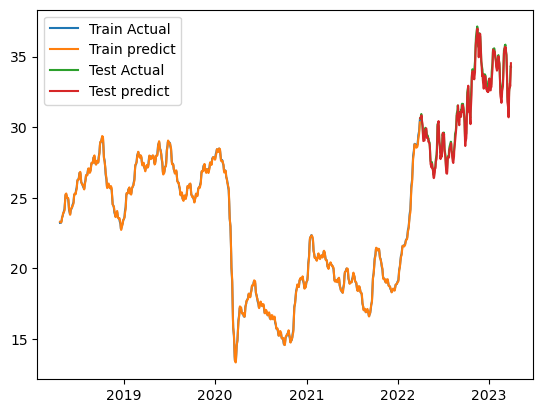

: 

In [57]:
obtain_all(2, show = True)